# **AI-Driven Hotel Detection to Combat Human Trafficking**
### **Yiyi Luo**

<img width="783" alt="Screenshot 2024-02-10 at 1 46 54 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/f2f482ac-e687-4ea0-a29b-227becb555c2">

## **Overview and Business Understanding**

Human trafficking is a grave violation of human rights, often leaving a digital trail in the form of photographs taken within hotel rooms. Identifying the hotels in these images is crucial for the success of trafficking investigations; however, it presents unique challenges. Investigators frequently face obstacles such as poor image quality, unconventional camera angles, and the subtle nuances of hotel room features.

This project aligns with the objectives of a notable Kaggle competition, aiming to leverage the power of machine learning to combat human trafficking by identifying hotel rooms from photographs. The competition, titled 'Hotel-ID to Combat Human Trafficking 2022 - FGVC9', presents an opportunity for participants to contribute to a crucial cause by addressing the challenges associated with hotel room identification. For more details on the competition please visit https://www.kaggle.com/competitions/hotel-id-to-combat-human-trafficking-2022-fgvc9/overview.

<img width="636" alt="Screenshot 2024-02-10 at 12 54 39 AM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/bbd1c72b-cb76-4371-9338-dc50e236825f">

**Import various modules and packages for image processing, machine learning, and deep learning, including TensorFlow, Keras, scikit-learn, PyTorch, and Hugging Face Transformers, preparing for image classification and model training.**

In [1]:
import os
from shutil import copy2
from collections import Counter
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import time
from tensorflow.keras.callbacks import Callback

#For Cross Validation 
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#For basic Keras model training
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Dropout

#For state-of-art pre-trained models
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, ResNet152V2, ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB6, EfficientNetV2S, EfficientNetV2M
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

#For ArcFace
import math
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Softmax
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

/Users/yiyiluo/miniconda3/envs/capstone/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Check and remove corrupted images**

In [ ]:
def delete_corrupted_images(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                continue

            file_path = os.path.join(root, filename)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"PIL cannot process {file_path}, deleting: {e}")
                os.remove(file_path)
                continue  

            try:
                image_bytes = tf.io.read_file(file_path)
                image = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
                image = tf.image.resize(image, [256, 256])
            except tf.errors.InvalidArgumentError as e:
                print(f"TensorFlow cannot process {file_path}, deleting: {e}")
                os.remove(file_path)

        for dirname in dirs:
            dir_path = os.path.join(root, dirname)
            if not os.listdir(dir_path):  
                print(f"Removing empty directory: {dir_path}")
                os.rmdir(dir_path)

directory = 'train_images'
delete_corrupted_images(directory)

## **Data Understanding and Overview**

In [20]:
dataset_path = 'train_images'

def analyze_images(dataset_path):
    hotel_image_counts = {}

    for hotel_id in os.listdir(dataset_path):
        hotel_dir = os.path.join(dataset_path, hotel_id)
        
        if os.path.isdir(hotel_dir):
            image_count = len([name for name in os.listdir(hotel_dir) if os.path.isfile(os.path.join(hotel_dir, name))])
            hotel_image_counts[hotel_id] = image_count

    total_hotels = len(hotel_image_counts)
    min_images = min(hotel_image_counts.values())
    max_images = max(hotel_image_counts.values())
    avg_images = sum(hotel_image_counts.values()) / total_hotels

    image_count_frequency = Counter(hotel_image_counts.values())

    top_20_common_counts = image_count_frequency.most_common(20)
    counts = [count for count, num_hotels in top_20_common_counts]
    hotels = [num_hotels for count, num_hotels in top_20_common_counts]

    
    print(f"Total number of hotels: {total_hotels}")
    print(f"Minimum number of images in a hotel: {min_images}")
    print(f"Maximum number of images in a hotel: {max_images}")
    print(f"Average number of images per hotel: {avg_images:.2f}")

analyze_images(dataset_path)

Total number of hotels: 1674
Minimum number of images in a hotel: 1
Maximum number of images in a hotel: 632
Average number of images per hotel: 13.29


<img width="700" alt="Screenshot 2024-02-11 at 5 20 47 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/129757f4-b138-4d4d-bcc9-ef76ac64cc9e">

### **Part I: Data Preprocessing**

**The process_images function resizes images, applies random red masks to them, and saves the processed images to a specified directory**

In [ ]:
#A function to resize images
def resize_image (image_path, target_size=(256,256)):
    """Resize an image to the target size."""
    image = load_img(image_path)
    image = image.resize(target_size)
    return image

#A funtion to apply masks
def apply_mask (image, mask):
    """Apply a red mask to an image."""
    image_array = img_to_array (image)
    mask_array = img_to_array (mask)
    #Maks's red color is the pure red color [255,0,0]
    red_mask = (mask_array[:,:,0] == 255) & (mask_array[:,:,1] == 0) & (mask_array[:,:,2] == 0)
    #Apply the red mask to each channel of the image
    image_array[red_mask] = [255,0,0] #This sets the color to red wherever the mask is present
    return array_to_img(image_array)

#A function to process the images by resizing and applying masks
def process_images(train_images_dir, train_masks_dir, output_dir, target_size=(256, 256)):
    """Process images by resizing and applying masks."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize a counter for processed images
    processed_count = 0

    # List all subdirectories in train_images_dir
    subdirs = [d for d in os.listdir(train_images_dir) if os.path.isdir(os.path.join(train_images_dir, d))]
    
    mask_files = [f for f in os.listdir(train_masks_dir) if f.lower().endswith('.png')]

    for subdir in subdirs:
        subdir_path = os.path.join(train_images_dir, subdir)
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')]

        for image_file in image_files:
            try:
                image_path = os.path.join(subdir_path, image_file)
                mask_file = random.choice(mask_files)  # Random mask for each image
                mask_path = os.path.join(train_masks_dir, mask_file)

                resized_image = resize_image(image_path, target_size)
                resized_mask = resize_image(mask_path, target_size)

                masked_image = apply_mask(resized_image, resized_mask)

                output_path = os.path.join(output_dir, f"{subdir}_{image_file}")
                masked_image.save(output_path)
                processed_count += 1
            except Exception as e:
                print (f"Error processing image {image_path}: {e}")

    print(f"Processed {processed_count} images and saved to {output_dir}")

def copy_files(files, source_dir, dest_dir):
    for f in files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

train_images_dir = 'train_images'
train_masks_dir = 'train_masks'
processed_images_dir ='processed_images'

if os.path.exists(processed_images_dir):
    shutil.rmtree(processed_images_dir)
os.makedirs(processed_images_dir)

process_images(train_images_dir, train_masks_dir, processed_images_dir)

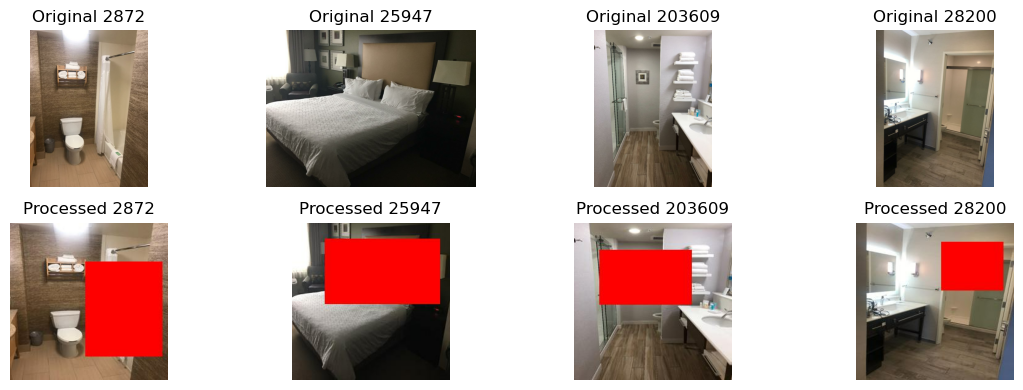

In [20]:
def plot_comparison_images(base_dir, processed_dir, num_samples=4):
    
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    plt.figure(figsize=(12, 4))
    
    for i, subdir in enumerate(subdirectories[:num_samples]):
        image_files = os.listdir(os.path.join(base_dir, subdir))
        image_file = image_files[0] if image_files else None
        
        if image_file:
            original_path = os.path.join(base_dir, subdir, image_file)
            original_image = tf.io.read_file(original_path)
            original_image = tf.image.decode_jpeg(original_image, channels=3)
            
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(original_image.numpy())
            plt.title(f"Original {subdir}")
            plt.axis("off")
            
            processed_path = os.path.join(processed_dir, subdir, image_file)
            processed_image = tf.io.read_file(processed_path)
            processed_image = tf.image.decode_jpeg(processed_image, channels=3)
            
            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(processed_image.numpy())
            plt.title(f"Processed {subdir}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

base_dir = 'train_images'
processed_dir = 'processed_images'

plot_comparison_images(base_dir, processed_dir)

**Challenge 1 - Class Diversity:** The dataset comprises a **large number of classes (1,674 distinct hotels)**, which presents a substantial challenge in terms of learning distinct features for each class.

**Challenge 2 - Class Imbalance:** There is **significant imbalance** in the dataset, with some hotels represented by a single image while others have over a thousand. This disparity can lead to overfitting and poor generalization for underrepresented classes.

**Challenge 3 - Insufficient Learning Samples:** Most hotels have **fewer than 15 images** available, which may not provide enough data for the model to effectively learn the variance within each class.

**Challenge 4 - Subtle Variations:** Hotel rooms often share similar aesthetics and structures, much like nuances in human faces, making it **difficult to distinguish between different hotels**.

**Challenge 6 - Potential Overfitting:** With a limited number of images per class, there is a risk of models overfitting to the training data, which could result in poor performance on unseen data.

**Challenge 7 - Background Noise and Variability:** The variability in lighting, decor, and camera angles within hotel room images introduces additional complexity, potentially leading to background noise that can confuse the model.

**In the initial phase of our project, due to constraints on time and computational resources, we have decided to prioritize training our models using unmodified images.** This step will allow us to establish a baseline performance and ensure that our models are learning effectively from the data in its most straightforward form. Following this, we plan to introduce a second phase of training, where the models will be further refined by including images with occlusions. 

**Create training and validation datasets from the 'train_images' directory, using TensorFlow to preprocess images into batches of 48 with a size of 256x256 pixels; Split the data into 70% for training and 30% for validation and testing**

In [3]:
directory = 'train_images'

full_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=48,
    image_size=(256,256),
    shuffle=True,
    seed=123,
    validation_split=0.3, 
    subset='training', 
    interpolation='bilinear', 
    follow_links=False,
    crop_to_aspect_ratio=False
)

full_validation_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=48,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.3,  
    subset='validation',  
    interpolation='bilinear',
    crop_to_aspect_ratio=False
)

Found 22244 files belonging to 1674 classes.
Using 15571 files for training.
Found 22244 files belonging to 1674 classes.
Using 6673 files for validation.


**Calculate the total number of batches in a validation and test dataset, split it evenly into two subsets for validation and testing**

In [4]:
total_batches = len(full_validation_test_dataset)
batches_per_subset = total_batches // 2

full_validation_dataset = full_validation_test_dataset.take(batches_per_subset)

full_test_dataset = full_validation_test_dataset.skip(batches_per_subset)

**Define a data augmentation pipeline using Keras, incorporating random flips, rotations, zooms, contrast and brightness adjustments, resizing to 280x280 pixels, cropping back to 256x256 pixels, and translations to enhance the diversity of the training dataset**

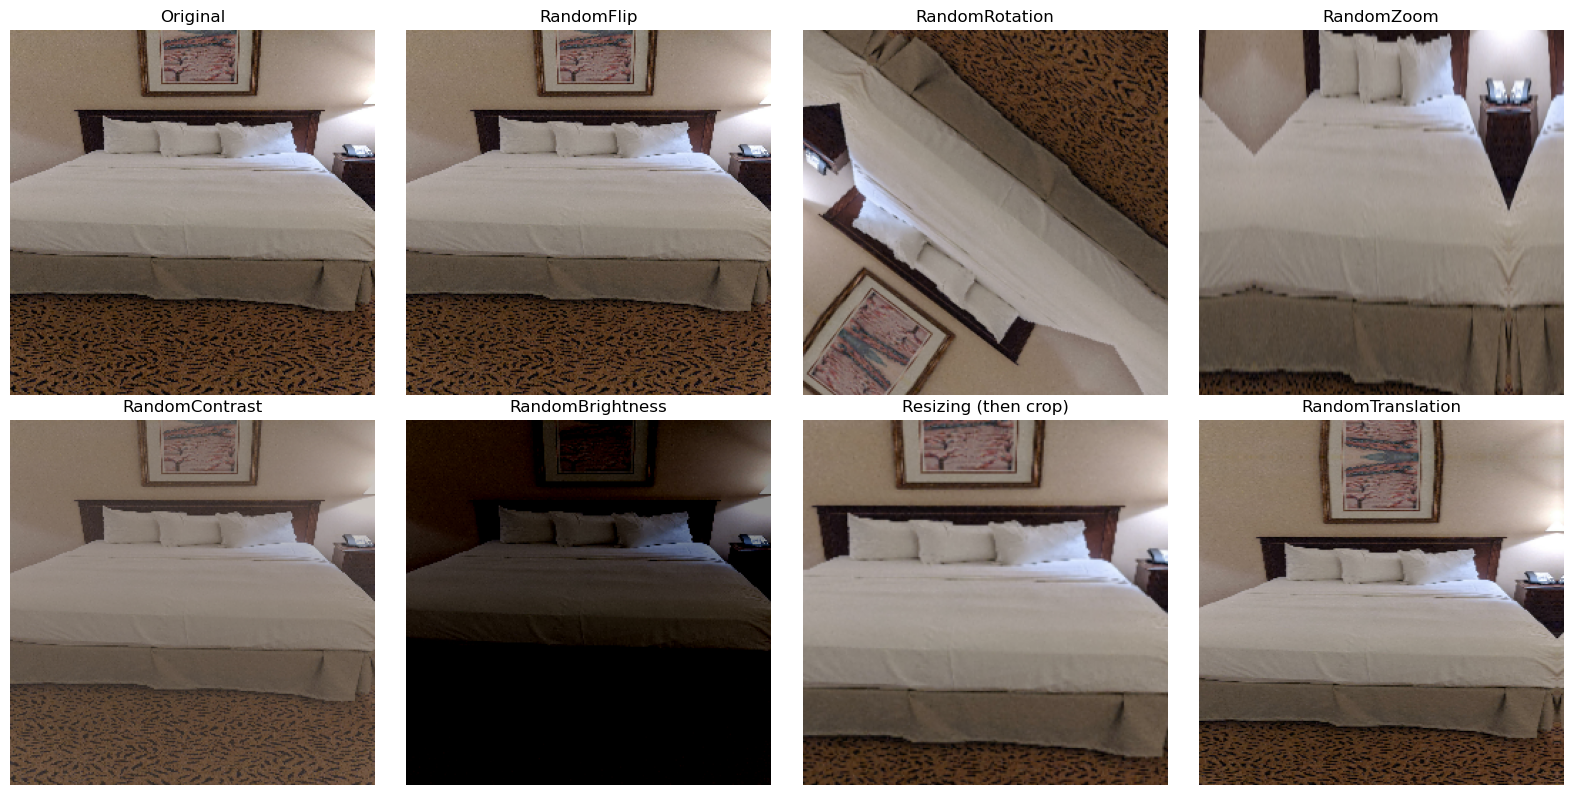

In [69]:
#To show the effects better in sample images, I chose to enhance the augmentations here; but in actual training I used the 'data_augmentation'
#function below
augmentations = [
    ('RandomFlip', layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3))),
    ('RandomRotation', layers.RandomRotation(0.5)),  
    ('RandomZoom', layers.RandomZoom(0.5, 0.5)),  
    ('RandomContrast', layers.RandomContrast(factor=0.5)),  
    ('RandomBrightness', layers.RandomBrightness(factor=0.5)),  
    ('Resizing (then crop)', keras.Sequential([
        layers.Resizing(320, 320),  
        layers.RandomCrop(height=256, width=256)
    ])),
    ('RandomTranslation', layers.RandomTranslation(height_factor=0.2, width_factor=0.2)),  
]

for images, _ in full_train_dataset.take(1):
    sample_image = images[0]
    break


plt.figure(figsize=(16, 8))  

plt.subplot(2, 4, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

for i, (name, augmentation) in enumerate(augmentations, start=2):
    augmented_image = augmentation(tf.expand_dims(sample_image, 0))
    
    plt.subplot(2, 4, i)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [70]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),  
        layers.RandomRotation(0.2),  
        layers.RandomZoom(0.2),  
        layers.RandomContrast(factor=0.1),  
        layers.RandomBrightness(factor=0.1),  
        layers.Resizing(280, 280),  
        layers.RandomCrop(height=256, width=256),  
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    ]
)


## **Part II: Basic Keras Models**

**Build a machine learning workflow for image classification using TensorFlow and Keras:**

**1.** **Set up essential parameters**: class names, the number of classes, and the number of epochs for training. The dataset is prepared using the ImageDataGenerator for image rescaling, ensuring proper input to the neural network;
   
**2.** A versatile model creation function is defined to **construct CNN models with optional data augmentation and dropout**, making it adaptable to various scenarios. The compile_and_train_model function takes care of compiling and training the models;

**3.** **Visualize training results** by the plot_training_history function, providing plots of training and validation accuracy and loss, aiding in the interpretation of the model's performance over epochs.
   
**4.** **Implements K-Fold cross-validation** to ensure the model's robustness and generalizability. It generates training and validation data generators for each fold, trains the model, and computes the average accuracy, offering a comprehensive evaluation of the model's performance.

In [8]:
class_names = full_train_dataset.class_names
num_classes = len(class_names)
epochs = 10
directory = 'full_train_dataset'
n_splits = 3

In [5]:
def create_model(num_classes, use_data_augmentation=False, dropout_rate=None):
    layers_list = []
    if use_data_augmentation:
        layers_list.append(data_augmentation)
    layers_list.extend([
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
    ])
    if dropout_rate is not None:
        layers_list.append(layers.Dropout(dropout_rate))
    layers_list.extend([
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return Sequential(layers_list)

def compile_and_train_model(model, train_ds, val_ds, epochs):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show
    

def cross_validate_model(create_model_func, model_params, epochs, n_splits):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=123)

    fold_no = 1
    scores = []

    for train_index, val_index in kfold.split(np.arange(total_batches)):
        print(f'Fold {fold_no} --')

        train_subset = tf.data.experimental.cardinality(full_train_dataset).numpy()
        val_subset = tf.data.experimental.cardinality(full_validation_dataset).numpy()

        train_batches = int(train_subset * len(train_index) / total_batches)
        val_batches = int(val_subset * len(val_index) / total_batches)

        train_ds = full_train_dataset.take(train_batches)
        val_ds = full_validation_dataset.skip(val_batches).take(val_batches)

        model = create_model_func(**model_params)
        compile_and_train_model(model, train_ds, val_ds, epochs)

        scores.append(model.evaluate(val_ds))

        fold_no += 1

    scores = np.array(scores)
    print('Scores for each fold:', scores)
    print('Average score:', np.mean(scores, axis=0))
    print('Standard deviation:', np.std(scores, axis=0))

**A basic Keras convolutional neural network model is created without any data augmentation or dropout features**

Epoch 1/10
325/325 [==============================] - 91s 277ms/step - loss: 7.1079 - accuracy: 0.0373 - val_loss: 6.9130 - val_accuracy: 0.0542
Epoch 2/10
325/325 [==============================] - 94s 285ms/step - loss: 6.7182 - accuracy: 0.0657 - val_loss: 6.8126 - val_accuracy: 0.0812
Epoch 3/10
325/325 [==============================] - 95s 288ms/step - loss: 6.3261 - accuracy: 0.0850 - val_loss: 6.7883 - val_accuracy: 0.0949
Epoch 4/10
325/325 [==============================] - 98s 298ms/step - loss: 5.8319 - accuracy: 0.1078 - val_loss: 7.2749 - val_accuracy: 0.0860
Epoch 5/10
325/325 [==============================] - 106s 322ms/step - loss: 5.1909 - accuracy: 0.1370 - val_loss: 7.7967 - val_accuracy: 0.0872
Epoch 6/10
325/325 [==============================] - 106s 323ms/step - loss: 4.4566 - accuracy: 0.1918 - val_loss: 8.9747 - val_accuracy: 0.0887
Epoch 7/10
325/325 [==============================] - 104s 318ms/step - loss: 3.6493 - accuracy: 0.2733 - val_loss: 10.1593 - va

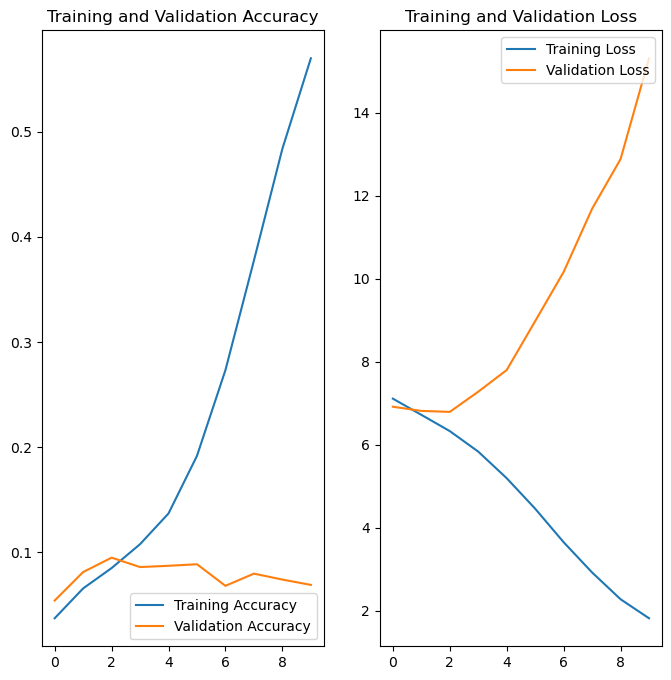

In [9]:
#Basic Keras model without data augmentation and dropout
model_basic = create_model(num_classes)
history_basic = compile_and_train_model(model_basic, full_train_dataset, full_validation_dataset, epochs)
plot_training_history(history_basic)

model_basic_config = {"func": create_model, "params": {"num_classes": num_classes}}
print("Running cross-validation for the basic Keras model")
average_accuracy_basic = cross_validate_model(model_basic_config['func'], model_basic_config['params'], epochs, n_splits)
print(f"Average accuracy for basic model: {average_accuracy_basic}")

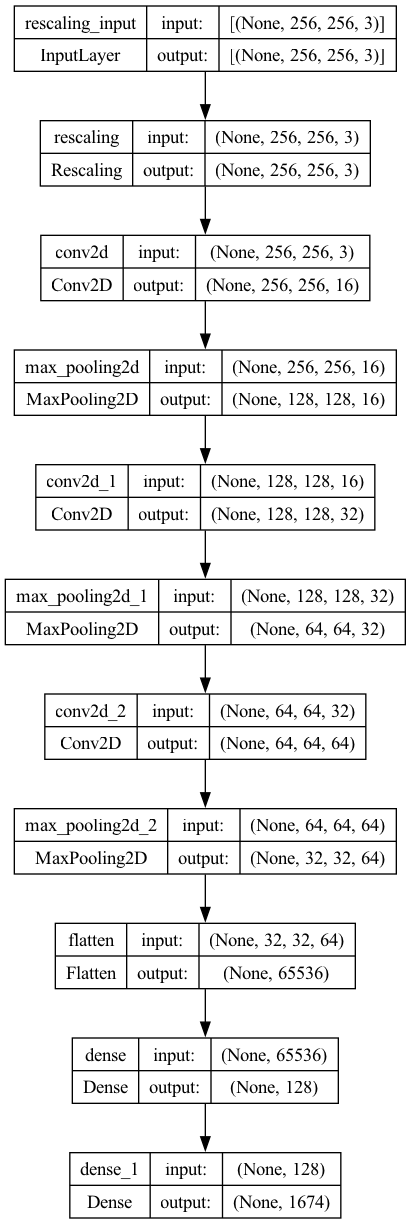

In [11]:
os.environ['PATH'] += os.pathsep + '/opt/homebrew/bin'
plot_model(model_basic, to_file='basic_model_architecture.png', show_shapes=True)
Image(filename='basic_model_architecture.png')

**Incorporating data augmentation to the Keras convolutional neural network model**

Epoch 1/10
325/325 [==============================] - 110s 335ms/step - loss: 7.1427 - accuracy: 0.0288 - val_loss: 7.0209 - val_accuracy: 0.0408
Epoch 2/10
325/325 [==============================] - 109s 333ms/step - loss: 6.9000 - accuracy: 0.0386 - val_loss: 6.8922 - val_accuracy: 0.0426
Epoch 3/10
325/325 [==============================] - 110s 335ms/step - loss: 6.7527 - accuracy: 0.0469 - val_loss: 6.9253 - val_accuracy: 0.0539
Epoch 4/10
325/325 [==============================] - 109s 333ms/step - loss: 6.6267 - accuracy: 0.0529 - val_loss: 6.8116 - val_accuracy: 0.0524
Epoch 5/10
325/325 [==============================] - 109s 333ms/step - loss: 6.5177 - accuracy: 0.0598 - val_loss: 6.7162 - val_accuracy: 0.0652
Epoch 6/10
325/325 [==============================] - 109s 333ms/step - loss: 6.4175 - accuracy: 0.0608 - val_loss: 6.7692 - val_accuracy: 0.0702
Epoch 7/10
325/325 [==============================] - 109s 332ms/step - loss: 6.3415 - accuracy: 0.0643 - val_loss: 6.6403 -

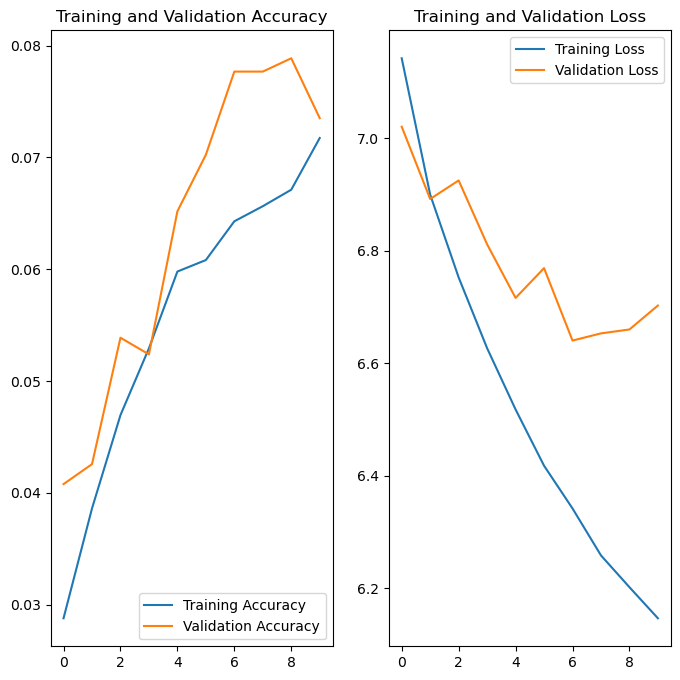

In [10]:
# Basic Keras Model with data augmentation
model_with_aug = create_model(num_classes, use_data_augmentation=True)
history_with_aug = compile_and_train_model(model_with_aug, full_train_dataset, full_validation_dataset, epochs)
plot_training_history(history_with_aug)

model_with_augmentation_config = {"func": create_model, "params": {"num_classes": num_classes, "use_data_augmentation": True}}
print("\nRunning cross-validation for the basic Keras model with augmentation")
average_accuracy_augmentation = cross_validate_model(model_with_augmentation_config['func'], model_with_augmentation_config['params'], epochs, n_splits)
print(f"Average accuracy for model with augmentation: {average_accuracy_augmentation}")

**Incorporating data augmentation and dropout to the Keras convolutional neural network model**

Epoch 1/10
325/325 [==============================] - 116s 353ms/step - loss: 7.1159 - accuracy: 0.0315 - val_loss: 6.9899 - val_accuracy: 0.0363
Epoch 2/10
325/325 [==============================] - 117s 358ms/step - loss: 6.8517 - accuracy: 0.0410 - val_loss: 6.8568 - val_accuracy: 0.0482
Epoch 3/10
325/325 [==============================] - 117s 358ms/step - loss: 6.7243 - accuracy: 0.0432 - val_loss: 6.8099 - val_accuracy: 0.0488
Epoch 4/10
325/325 [==============================] - 113s 343ms/step - loss: 6.6166 - accuracy: 0.0480 - val_loss: 6.8467 - val_accuracy: 0.0685
Epoch 5/10
325/325 [==============================] - 110s 336ms/step - loss: 6.5402 - accuracy: 0.0530 - val_loss: 6.9796 - val_accuracy: 0.0637
Epoch 6/10
325/325 [==============================] - 110s 334ms/step - loss: 6.4271 - accuracy: 0.0581 - val_loss: 6.7130 - val_accuracy: 0.0705
Epoch 7/10
325/325 [==============================] - 109s 332ms/step - loss: 6.3166 - accuracy: 0.0642 - val_loss: 6.6500 -

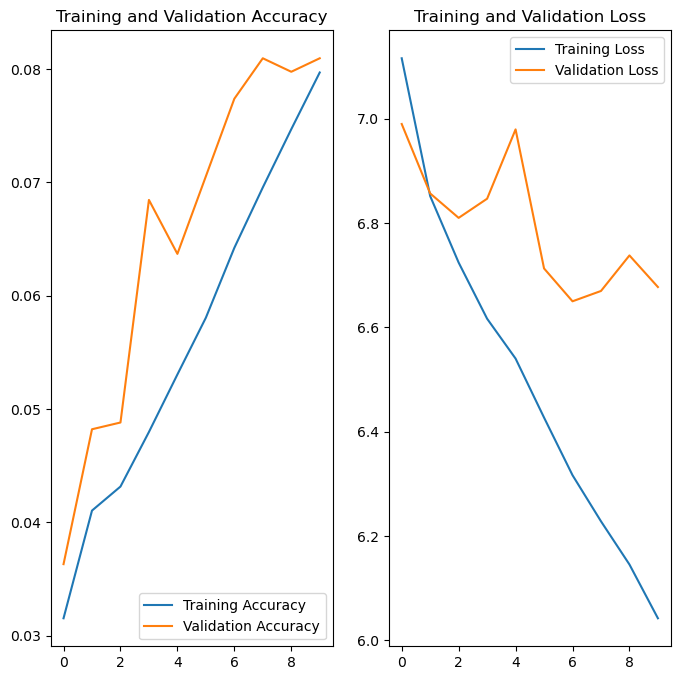

In [11]:
# Basic Keras Model with data augmentation and dropout
model_dropout_aug = create_model(num_classes, use_data_augmentation=True, dropout_rate=0.2)
history_dropout_aug = compile_and_train_model(model_dropout_aug, full_train_dataset, full_validation_dataset, epochs)
plot_training_history(history_dropout_aug)

model_with_augmen_dropout_config = {"func": create_model, "params": {"num_classes": num_classes, "use_data_augmentation": True, "dropout_rate": 0.2}}
print("\nRunning cross-validation for the basic Keras model with augmentation and dropout")
average_accuracy_dropout = cross_validate_model(model_with_augmen_dropout_config['func'], model_with_augmen_dropout_config['params'], epochs, n_splits)
print(f"Average accuracy for model with augmentation and dropout: {average_accuracy_dropout}")

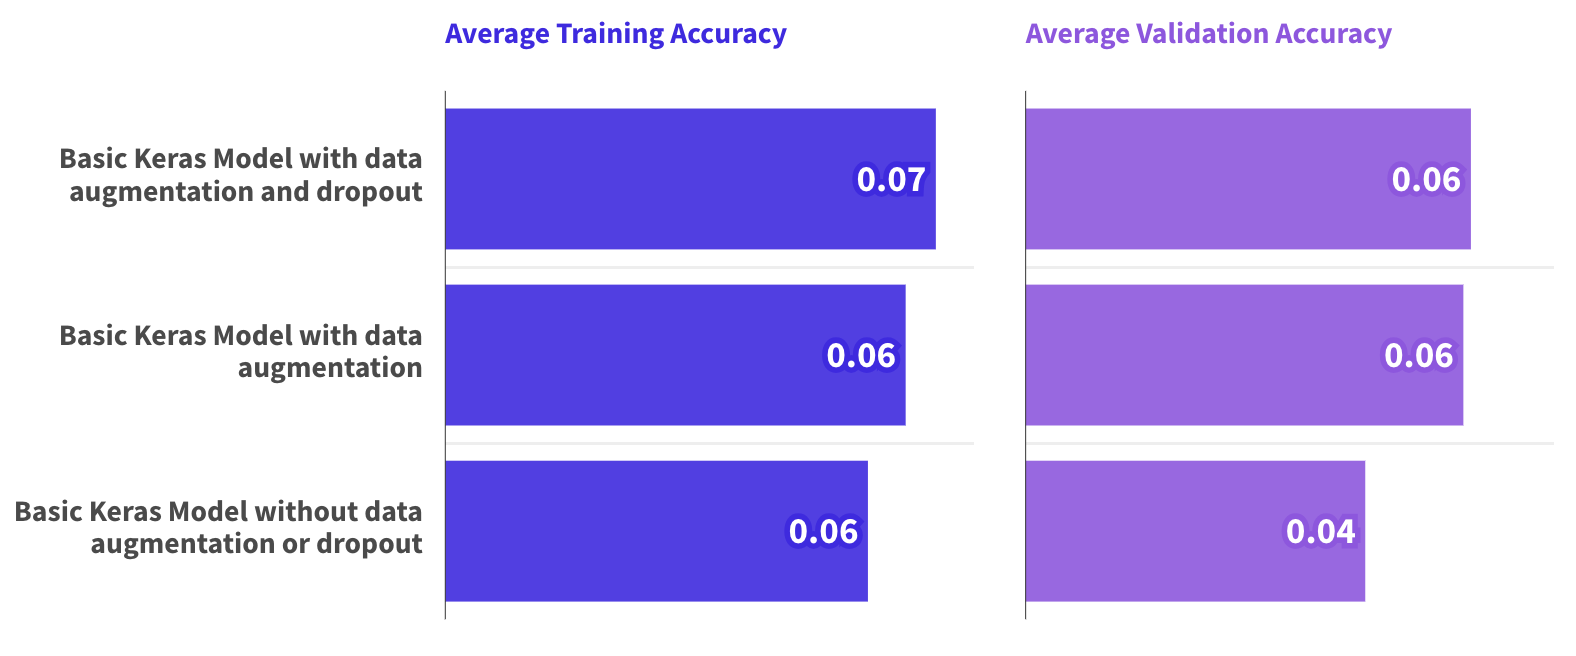

## **Part III: More advanced and pre-trained convolutional neural network models**

**The limitations of a basic Keras model** in handling such a complex and nuanced task stem from its typically shallow architecture, which might lack the capacity to capture the subtle differences between highly similar hotel rooms. 

While **VGG and Inception**, the deeper convolutional neural networks, offer improvements by delving deeper into the image structure through its multiple layers.

Given the extensive size of our dataset, comprising **22,244 images across 1,674 classes**, coupled with the constraints of **limited computational resources**, we opted for a strategic approach. We **selected a smaller subset of the dataset (the top 500 classes with the most images)** to conduct preliminary tests on various deeper CNN pre-trained models. By concentrating on **tweaking the top-performing models**, we plan to gradually make them even better. This careful way of doing things helps us deal with our limited resources and still get the best results we can.

In [21]:
full_dataset_directory = "train_images"

image_counts = {}

for class_dir in os.listdir(full_dataset_directory):
    class_path = os.path.join(full_dataset_directory, class_dir)
    if os.path.isdir(class_path):
        image_counts[class_dir] = len([entry for entry in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, entry))])

top_500_classes = Counter(image_counts).most_common(500)

subset_directory = "subset_top_500_hotels"  
os.makedirs(subset_directory, exist_ok=True)

for class_dir, _ in top_500_classes:
    original_class_path = os.path.join(full_dataset_directory, class_dir)
    subset_class_path = os.path.join(subset_directory, class_dir)
    os.makedirs(subset_class_path, exist_ok=True)
    
    for image in os.listdir(original_class_path):
        src_image_path = os.path.join(original_class_path, image)
        dst_image_path = os.path.join(subset_class_path, image)
        copy2(src_image_path, dst_image_path)

print("The subset with the top 500 classes has been created.")

The subset with the top 500 classes has been created.


In [22]:
dataset_path = 'subset_top_500_hotels'
analyze_images(dataset_path)

Total number of hotels: 500
Minimum number of images in a hotel: 12
Maximum number of images in a hotel: 632
Average number of images per hotel: 27.01


<img width="700" alt="Screenshot 2024-02-11 at 5 20 24 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/ac53a188-a7c8-4ca5-98f5-b5ef7725470e">

In [4]:
subset_directory = 'subset_top_500_hotels'

subset_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=subset_directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=48,
    image_size=(256,256),
    shuffle=True,
    seed=123,
    validation_split=0.3, 
    subset='training', 
    interpolation='bilinear', 
    follow_links=False,
    crop_to_aspect_ratio=False
)

subset_validation_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=subset_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=48,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.3,  
    subset='validation',  
    interpolation='bilinear',
    crop_to_aspect_ratio=False
)

total_batches = len(subset_validation_test_dataset)
batches_per_subset = total_batches // 2
subset_validation_dataset = subset_validation_test_dataset.take(batches_per_subset)
subset_test_dataset = subset_validation_test_dataset.skip(batches_per_subset)

Found 13504 files belonging to 500 classes.
Using 9453 files for training.
Found 13504 files belonging to 500 classes.
Using 4051 files for validation.


In [78]:
def prepare_model(model_name, num_classes, input_shape=(256, 256, 3), learning_rate=0.001):
    if model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'ResNet152V2':
        base_model = ResNet152V2(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'ResNet101':
        base_model = ResNet101(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'EfficientNetB6':
        base_model = EfficientNetB6(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'EfficientNetV2S':
        base_model = EfficientNetV2S(include_top=False, input_shape=input_shape, weights='imagenet')
    elif model_name == 'EfficientNetV2M':
        base_model = EfficientNetV2M(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = Dense(1024, activation='relu')(x)  
    output = Dense(num_classes, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_start_time)

    def on_train_end(self, logs={}):
        self.average_time_per_epoch = sum(self.times) / len(self.times)
        print(f"Average time per epoch: {self.average_time_per_epoch:.2f} seconds")

time_callback = TimeHistory()

def train_model(model, train_dataset, validation_dataset, epochs=10):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10,
        verbose=1,
        callbacks=[time_callback]
    )
    return history

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**VGG-16:** Progress from a basic Keras model to the more advanced and pre-trained VGG-16 model for image classification. **VGG-16 is a powerful convolutional neural network pre-trained on the ImageNet dataset**, we are hoping to leverage deeper and more complex architectures that have been proven effective on a wide range of image recognition tasks.

In [79]:
class_names = subset_train_dataset.class_names
num_classes = len(class_names)

Epoch 1/10
197/197 [==============================] - 617s 3s/step - loss: 5.7164 - accuracy: 0.1448 - val_loss: 5.1754 - val_accuracy: 0.1796
Epoch 2/10
197/197 [==============================] - 636s 3s/step - loss: 4.3128 - accuracy: 0.2263 - val_loss: 4.8996 - val_accuracy: 0.2098
Epoch 3/10
197/197 [==============================] - 632s 3s/step - loss: 3.2326 - accuracy: 0.3499 - val_loss: 4.8968 - val_accuracy: 0.2302
Epoch 4/10
197/197 [==============================] - 594s 3s/step - loss: 2.3482 - accuracy: 0.4921 - val_loss: 5.0291 - val_accuracy: 0.2470
Epoch 5/10
197/197 [==============================] - 597s 3s/step - loss: 1.6360 - accuracy: 0.6290 - val_loss: 5.1356 - val_accuracy: 0.2619
Epoch 6/10
197/197 [==============================] - 603s 3s/step - loss: 1.0845 - accuracy: 0.7429 - val_loss: 5.6869 - val_accuracy: 0.2594
Epoch 7/10
197/197 [==============================] - 610s 3s/step - loss: 0.7002 - accuracy: 0.8368 - val_loss: 5.9860 - val_accuracy: 0.2664

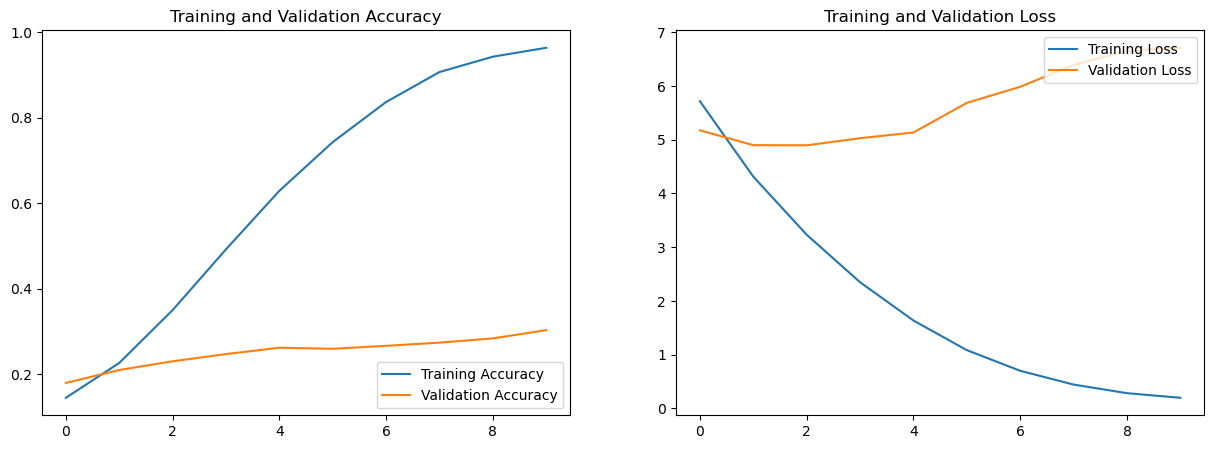

Average Validation Accuracy: 0.25
Average epoch time: 615.21 seconds


In [81]:
model_name = 'VGG16'  
model_VGG16 = prepare_model(model_name, num_classes)
history = train_model(model_VGG16, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 151s 758ms/step - loss: 11.7725 - accuracy: 0.0259 - val_loss: 6.0962 - val_accuracy: 0.0342
Epoch 2/10
197/197 [==============================] - 149s 751ms/step - loss: 5.9628 - accuracy: 0.0645 - val_loss: 5.9376 - val_accuracy: 0.0823
Epoch 3/10
197/197 [==============================] - 148s 745ms/step - loss: 5.7802 - accuracy: 0.0845 - val_loss: 5.8505 - val_accuracy: 0.0863
Epoch 4/10
197/197 [==============================] - 148s 744ms/step - loss: 5.6530 - accuracy: 0.0860 - val_loss: 5.7790 - val_accuracy: 0.0804
Epoch 5/10
197/197 [==============================] - 147s 742ms/step - loss: 5.5903 - accuracy: 0.0884 - val_loss: 5.7009 - val_accuracy: 0.0789
Epoch 6/10
197/197 [==============================] - 148s 746ms/step - loss: 5.5461 - accuracy: 0.0964 - val_loss: 5.6608 - val_accuracy: 0.0799
Epoch 7/10
197/197 [==============================] - 148s 746ms/step - loss: 5.5162 - accuracy: 0.0936 - val_loss: 5.6486 

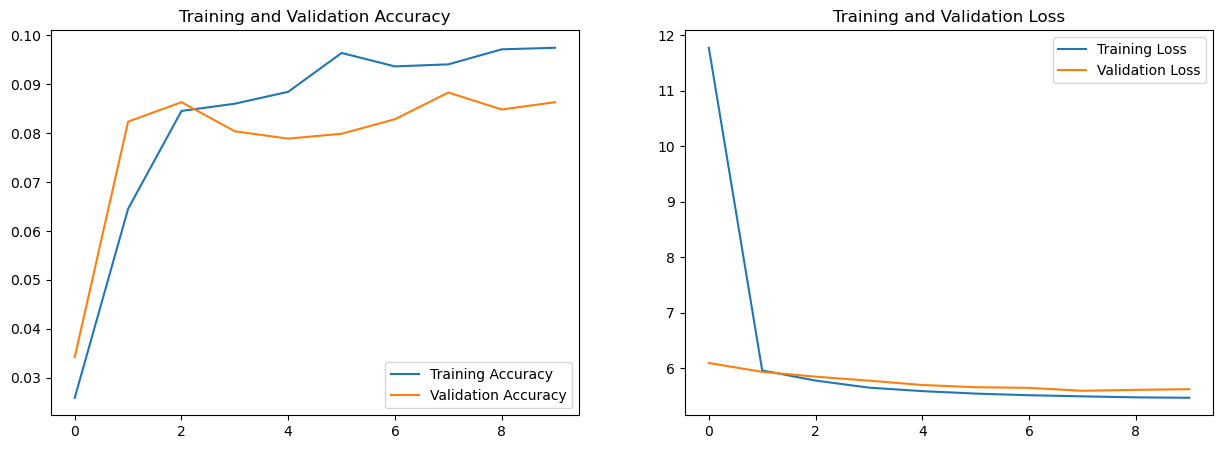

Average Validation Accuracy: 0.08
Average epoch time: 148.10 seconds


In [82]:
model_name = 'InceptionV3'  
model_InceptionV3 = prepare_model(model_name, num_classes)
history = train_model(model_InceptionV3, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

**VGG and Inception** represent earlier convolutional neural network (CNN) designs focusing on **depth** and **multi-scale** processing, while models like **ResNet, DenseNet, and EfficientNet** are more advanced iterations that incorporate additional mechanisms to handle the challenges of deeper network structures. 

**ResNet** introduces a novel approach to facilitate training deeper networks through skip connections;

**DenseNet** streamlines the training of deep architectures by densely connecting each layer to every other layer, ensuring maximum information flow between layers. This design not only enhances performance with a more efficient parameter usage but also helps alleviate the vanishing-gradient problem, making deep networks easier to train;

**EfficientNet** optimizes CNN scaling by uniformly increasing depth, width, and resolution with fixed coefficients, leading to state-of-the-art performance on image classification tasks. 

Epoch 1/10
197/197 [==============================] - 478s 2s/step - loss: 162.7279 - accuracy: 0.0048 - val_loss: 6.2020 - val_accuracy: 0.0045
Epoch 2/10
197/197 [==============================] - 479s 2s/step - loss: 6.3587 - accuracy: 0.0262 - val_loss: 6.1804 - val_accuracy: 0.0298
Epoch 3/10
197/197 [==============================] - 480s 2s/step - loss: 6.1634 - accuracy: 0.0309 - val_loss: 6.1563 - val_accuracy: 0.0283
Epoch 4/10
197/197 [==============================] - 481s 2s/step - loss: 6.1362 - accuracy: 0.0362 - val_loss: 6.1307 - val_accuracy: 0.0427
Epoch 5/10
197/197 [==============================] - 467s 2s/step - loss: 6.1086 - accuracy: 0.0486 - val_loss: 6.1071 - val_accuracy: 0.0427
Epoch 6/10
197/197 [==============================] - 468s 2s/step - loss: 6.0811 - accuracy: 0.0486 - val_loss: 6.0792 - val_accuracy: 0.0441
Epoch 7/10
197/197 [==============================] - 473s 2s/step - loss: 6.0539 - accuracy: 0.0486 - val_loss: 6.0582 - val_accuracy: 0.04

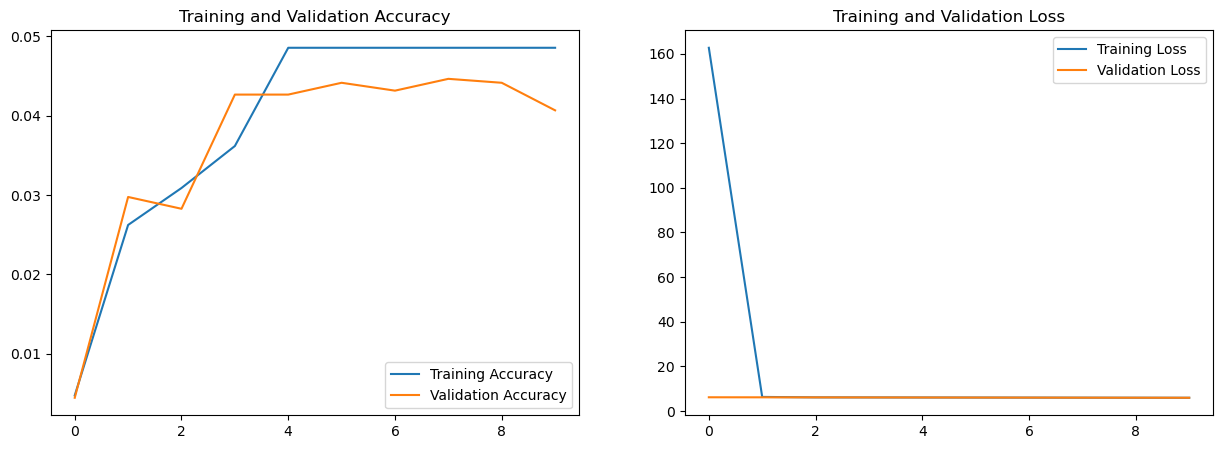

Average Validation Accuracy: 0.04
Average epoch time: 476.96 seconds


In [83]:
model_name = 'ResNet152V2'  
model_ResNet152V2 = prepare_model(model_name, num_classes)
history = train_model(model_ResNet152V2, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 364s 2s/step - loss: 5.3325 - accuracy: 0.1608 - val_loss: 4.9343 - val_accuracy: 0.1855
Epoch 2/10
197/197 [==============================] - 374s 2s/step - loss: 4.2757 - accuracy: 0.2406 - val_loss: 4.5012 - val_accuracy: 0.2302
Epoch 3/10
197/197 [==============================] - 377s 2s/step - loss: 3.3419 - accuracy: 0.3461 - val_loss: 4.3786 - val_accuracy: 0.2624
Epoch 4/10
197/197 [==============================] - 365s 2s/step - loss: 2.5141 - accuracy: 0.4724 - val_loss: 4.2951 - val_accuracy: 0.2857
Epoch 5/10
197/197 [==============================] - 372s 2s/step - loss: 1.8625 - accuracy: 0.5892 - val_loss: 4.3108 - val_accuracy: 0.2996
Epoch 6/10
197/197 [==============================] - 369s 2s/step - loss: 1.3270 - accuracy: 0.7023 - val_loss: 4.4373 - val_accuracy: 0.3080
Epoch 7/10
197/197 [==============================] - 375s 2s/step - loss: 0.9512 - accuracy: 0.7912 - val_loss: 4.4696 - val_accuracy: 0.3224

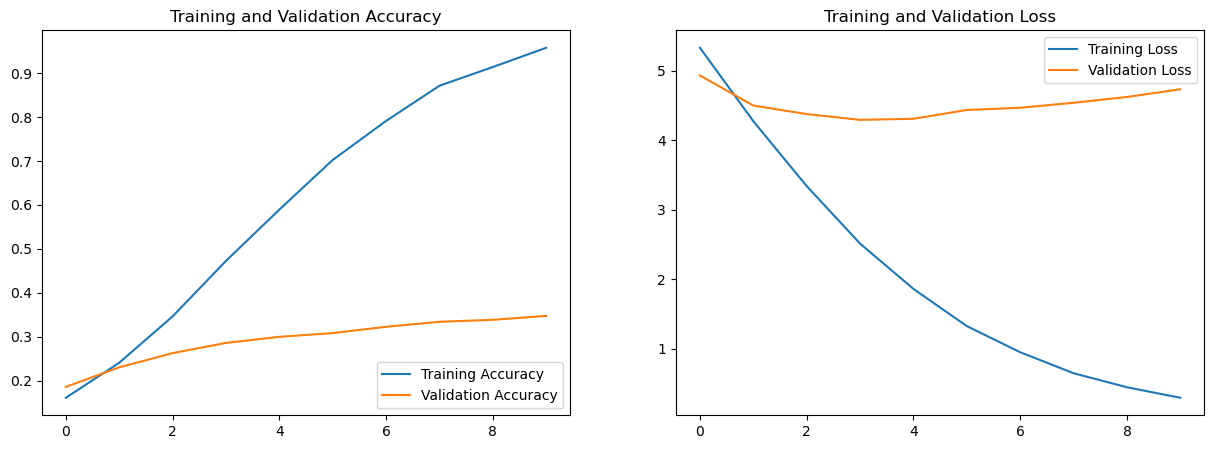

Average Validation Accuracy: 0.29
Average epoch time: 372.15 seconds


In [84]:
model_name = 'ResNet101'  
model_ResNet101 = prepare_model(model_name, num_classes)
history = train_model(model_ResNet101, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 219s 1s/step - loss: 5.3459 - accuracy: 0.1620 - val_loss: 4.9531 - val_accuracy: 0.1880
Epoch 2/10
197/197 [==============================] - 214s 1s/step - loss: 4.3098 - accuracy: 0.2365 - val_loss: 4.5661 - val_accuracy: 0.2321
Epoch 3/10
197/197 [==============================] - 218s 1s/step - loss: 3.4349 - accuracy: 0.3268 - val_loss: 4.3156 - val_accuracy: 0.2535
Epoch 4/10
197/197 [==============================] - 220s 1s/step - loss: 2.6580 - accuracy: 0.4449 - val_loss: 4.1695 - val_accuracy: 0.2907
Epoch 5/10
197/197 [==============================] - 213s 1s/step - loss: 2.0441 - accuracy: 0.5531 - val_loss: 4.2000 - val_accuracy: 0.2946
Epoch 6/10
197/197 [==============================] - 217s 1s/step - loss: 1.5559 - accuracy: 0.6493 - val_loss: 4.1556 - val_accuracy: 0.3214
Epoch 7/10
197/197 [==============================] - 231s 1s/step - loss: 1.1658 - accuracy: 0.7427 - val_loss: 4.2479 - val_accuracy: 0.3234

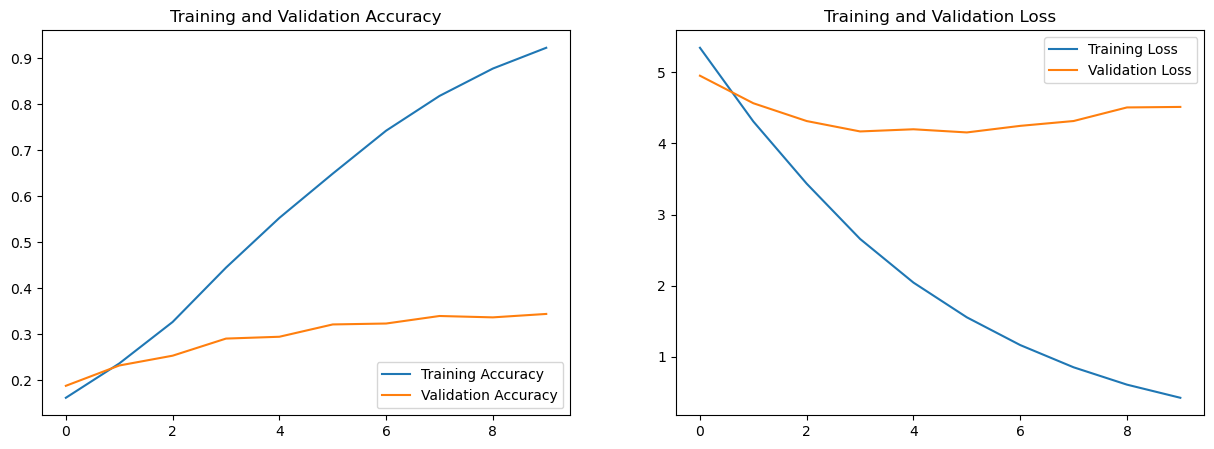

Average Validation Accuracy: 0.29
Average epoch time: 218.42 seconds


In [85]:
model_name = 'ResNet50'  
model_ResNet50 = prepare_model(model_name, num_classes)
history = train_model(model_ResNet50, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 213s 1s/step - loss: 5.9072 - accuracy: 0.1113 - val_loss: 5.3730 - val_accuracy: 0.1374
Epoch 2/10
197/197 [==============================] - 211s 1s/step - loss: 4.9716 - accuracy: 0.1639 - val_loss: 5.0791 - val_accuracy: 0.1751
Epoch 3/10
197/197 [==============================] - 214s 1s/step - loss: 4.5645 - accuracy: 0.1906 - val_loss: 4.9890 - val_accuracy: 0.1751
Epoch 4/10
197/197 [==============================] - 212s 1s/step - loss: 4.2785 - accuracy: 0.2158 - val_loss: 4.8458 - val_accuracy: 0.1885
Epoch 5/10
197/197 [==============================] - 212s 1s/step - loss: 4.0062 - accuracy: 0.2412 - val_loss: 4.8682 - val_accuracy: 0.2039
Epoch 6/10
197/197 [==============================] - 222s 1s/step - loss: 3.7376 - accuracy: 0.2717 - val_loss: 4.8825 - val_accuracy: 0.2108
Epoch 7/10
197/197 [==============================] - 223s 1s/step - loss: 3.5229 - accuracy: 0.2983 - val_loss: 4.7950 - val_accuracy: 0.2183

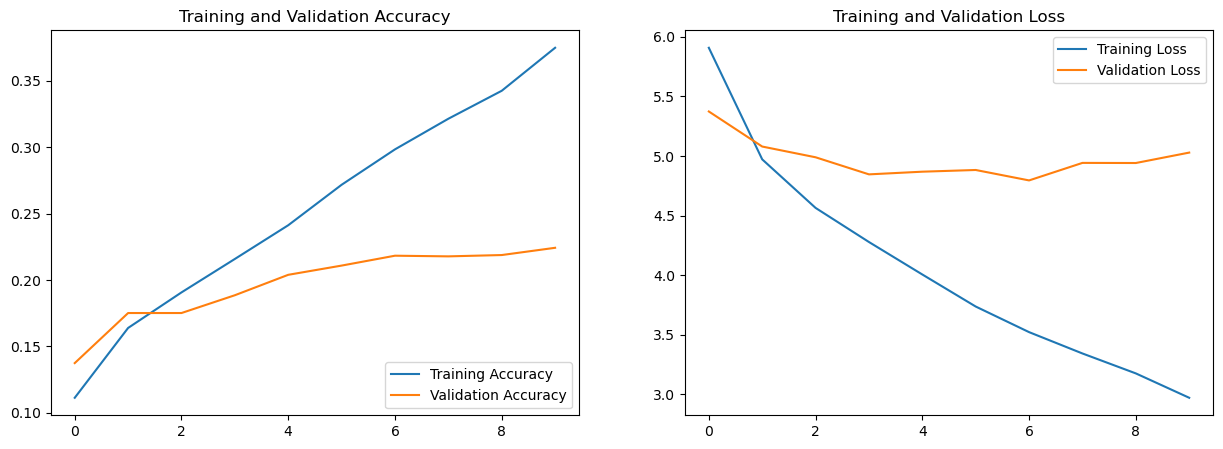

Average Validation Accuracy: 0.20
Average epoch time: 217.45 seconds


In [86]:
model_name = 'DenseNet121'  
model_DenseNet121 = prepare_model(model_name, num_classes)
history = train_model(model_DenseNet121, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 563s 3s/step - loss: 5.2819 - accuracy: 0.1634 - val_loss: 4.9160 - val_accuracy: 0.1959
Epoch 2/10
197/197 [==============================] - 564s 3s/step - loss: 3.8859 - accuracy: 0.2780 - val_loss: 4.5965 - val_accuracy: 0.2436
Epoch 3/10
197/197 [==============================] - 566s 3s/step - loss: 2.6460 - accuracy: 0.4553 - val_loss: 4.5675 - val_accuracy: 0.2862
Epoch 4/10
197/197 [==============================] - 571s 3s/step - loss: 1.7132 - accuracy: 0.6267 - val_loss: 4.5525 - val_accuracy: 0.3070
Epoch 5/10
197/197 [==============================] - 565s 3s/step - loss: 1.0933 - accuracy: 0.7615 - val_loss: 4.5149 - val_accuracy: 0.3363
Epoch 6/10
197/197 [==============================] - 541s 3s/step - loss: 0.6823 - accuracy: 0.8556 - val_loss: 4.6715 - val_accuracy: 0.3477
Epoch 7/10
197/197 [==============================] - 540s 3s/step - loss: 0.4287 - accuracy: 0.9148 - val_loss: 4.6316 - val_accuracy: 0.3700

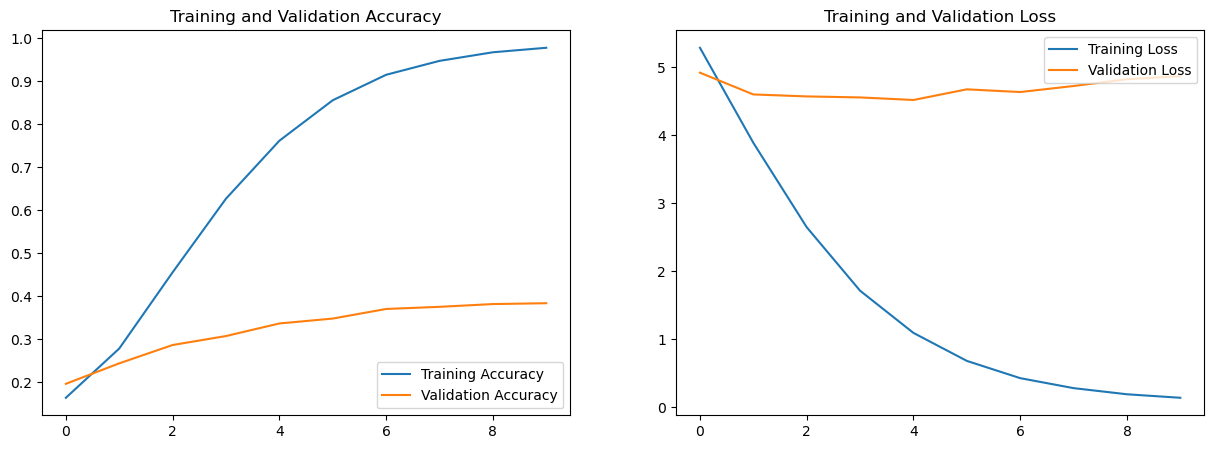

Average Validation Accuracy: 0.32
Average epoch time: 559.52 seconds


In [87]:
model_name = 'EfficientNetB7'  
model_EfficientNetB7 = prepare_model(model_name, num_classes)
history = train_model(model_EfficientNetB7, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 404s 2s/step - loss: 5.3651 - accuracy: 0.1500 - val_loss: 4.9466 - val_accuracy: 0.1939
Epoch 2/10
197/197 [==============================] - 412s 2s/step - loss: 4.0867 - accuracy: 0.2520 - val_loss: 4.7041 - val_accuracy: 0.2316
Epoch 3/10
197/197 [==============================] - 409s 2s/step - loss: 2.9829 - accuracy: 0.3915 - val_loss: 4.6203 - val_accuracy: 0.2669
Epoch 4/10
197/197 [==============================] - 409s 2s/step - loss: 2.0901 - accuracy: 0.5451 - val_loss: 4.5900 - val_accuracy: 0.2961
Epoch 5/10
197/197 [==============================] - 408s 2s/step - loss: 1.4431 - accuracy: 0.6778 - val_loss: 4.7344 - val_accuracy: 0.3100
Epoch 6/10
197/197 [==============================] - 410s 2s/step - loss: 0.9904 - accuracy: 0.7837 - val_loss: 4.7656 - val_accuracy: 0.3284
Epoch 7/10
197/197 [==============================] - 408s 2s/step - loss: 0.6789 - accuracy: 0.8515 - val_loss: 4.8422 - val_accuracy: 0.3467

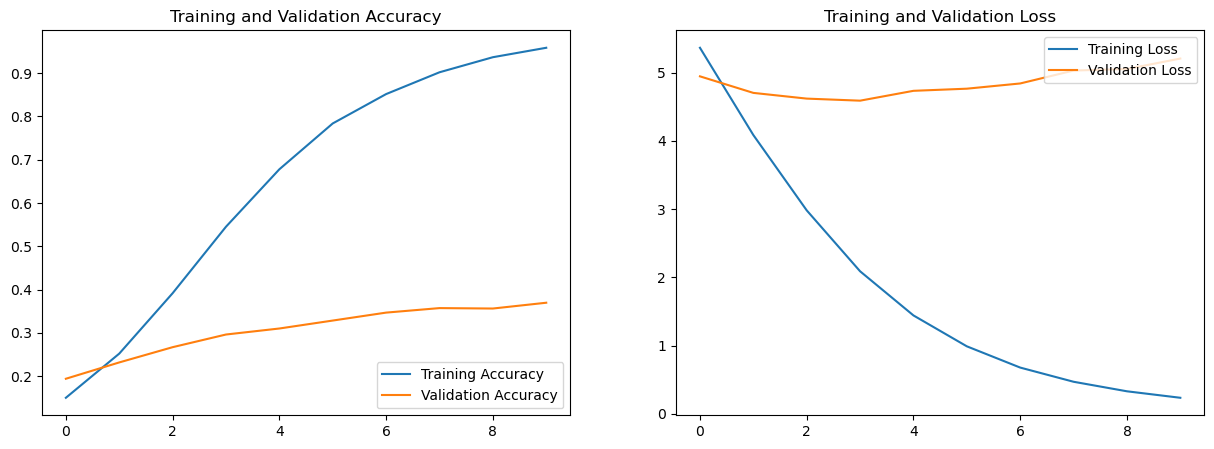

Average Validation Accuracy: 0.31
Average epoch time: 404.21 seconds


In [88]:
model_name = 'EfficientNetB6'  
model_EfficientNetB6 = prepare_model(model_name, num_classes)
history = train_model(model_EfficientNetB6, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 84s 416ms/step - loss: 5.2113 - accuracy: 0.1738 - val_loss: 4.7130 - val_accuracy: 0.2158
Epoch 2/10
197/197 [==============================] - 83s 416ms/step - loss: 3.6422 - accuracy: 0.3097 - val_loss: 4.2455 - val_accuracy: 0.2882
Epoch 3/10
197/197 [==============================] - 81s 404ms/step - loss: 2.2795 - accuracy: 0.5301 - val_loss: 3.9662 - val_accuracy: 0.3373
Epoch 4/10
197/197 [==============================] - 81s 404ms/step - loss: 1.3365 - accuracy: 0.7251 - val_loss: 3.8185 - val_accuracy: 0.3800
Epoch 5/10
197/197 [==============================] - 86s 430ms/step - loss: 0.7561 - accuracy: 0.8539 - val_loss: 3.8547 - val_accuracy: 0.4043
Epoch 6/10
197/197 [==============================] - 90s 452ms/step - loss: 0.4294 - accuracy: 0.9265 - val_loss: 3.8947 - val_accuracy: 0.4152
Epoch 7/10
197/197 [==============================] - 89s 446ms/step - loss: 0.2471 - accuracy: 0.9671 - val_loss: 3.8629 - val_ac

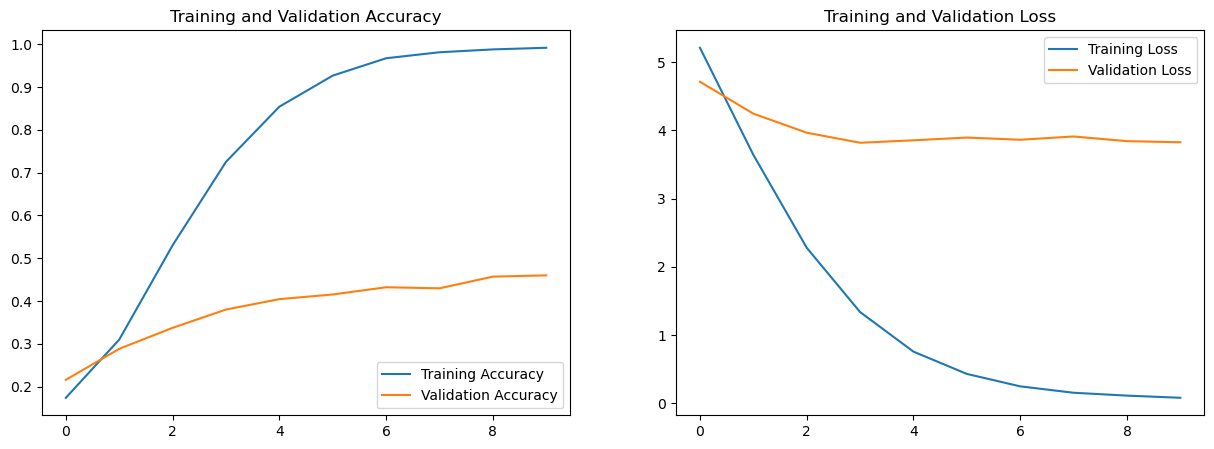

Average Validation Accuracy: 0.38
Average epoch time: 85.61 seconds


In [80]:
model_name = 'EfficientNetB0'  
model_EfficientNetB0 = prepare_model(model_name, num_classes)
history = train_model(model_EfficientNetB0, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 218s 1s/step - loss: 5.3925 - accuracy: 0.1484 - val_loss: 4.9918 - val_accuracy: 0.1910
Epoch 2/10
197/197 [==============================] - 213s 1s/step - loss: 4.2117 - accuracy: 0.2402 - val_loss: 4.6818 - val_accuracy: 0.2316
Epoch 3/10
197/197 [==============================] - 218s 1s/step - loss: 3.2383 - accuracy: 0.3566 - val_loss: 4.6129 - val_accuracy: 0.2619
Epoch 4/10
197/197 [==============================] - 216s 1s/step - loss: 2.4296 - accuracy: 0.4868 - val_loss: 4.5946 - val_accuracy: 0.2872
Epoch 5/10
197/197 [==============================] - 219s 1s/step - loss: 1.8137 - accuracy: 0.6021 - val_loss: 4.5376 - val_accuracy: 0.3170
Epoch 6/10
197/197 [==============================] - 216s 1s/step - loss: 1.3585 - accuracy: 0.6952 - val_loss: 4.5548 - val_accuracy: 0.3348
Epoch 7/10
197/197 [==============================] - 216s 1s/step - loss: 1.0220 - accuracy: 0.7692 - val_loss: 4.5956 - val_accuracy: 0.3606

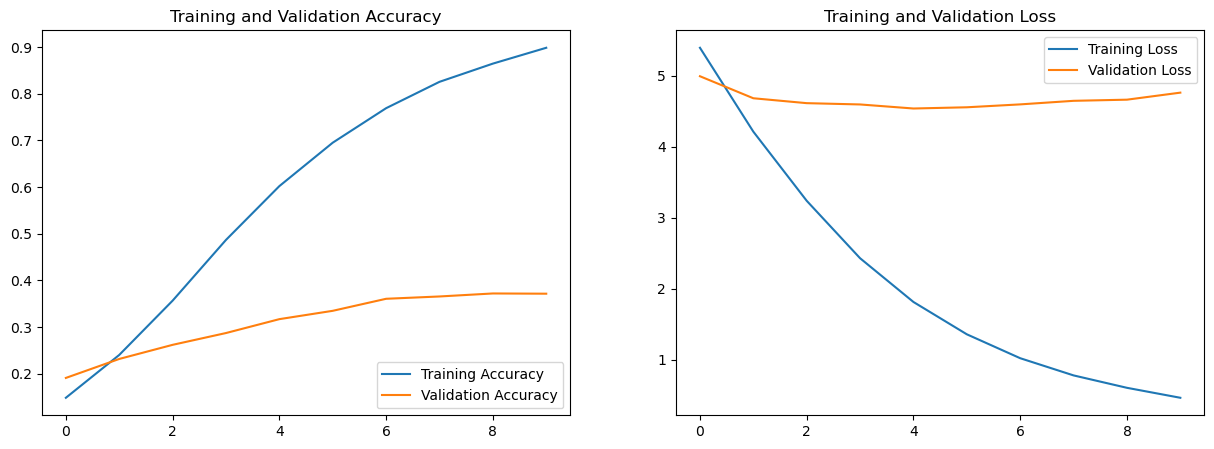

Average Validation Accuracy: 0.31
Average epoch time: 218.39 seconds


In [89]:
model_name = 'EfficientNetV2S'  
model_EfficientNetV2S = prepare_model(model_name, num_classes)
history = train_model(model_EfficientNetV2S, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

Epoch 1/10
197/197 [==============================] - 341s 2s/step - loss: 5.5011 - accuracy: 0.1343 - val_loss: 5.1475 - val_accuracy: 0.1716
Epoch 2/10
197/197 [==============================] - 329s 2s/step - loss: 4.4952 - accuracy: 0.2066 - val_loss: 4.8701 - val_accuracy: 0.2153
Epoch 3/10
197/197 [==============================] - 332s 2s/step - loss: 3.6860 - accuracy: 0.2902 - val_loss: 4.8116 - val_accuracy: 0.2346
Epoch 4/10
197/197 [==============================] - 338s 2s/step - loss: 3.0029 - accuracy: 0.3889 - val_loss: 4.8462 - val_accuracy: 0.2490
Epoch 5/10
197/197 [==============================] - 339s 2s/step - loss: 2.4477 - accuracy: 0.4797 - val_loss: 4.8637 - val_accuracy: 0.2574
Epoch 6/10
197/197 [==============================] - 338s 2s/step - loss: 1.9989 - accuracy: 0.5637 - val_loss: 4.8570 - val_accuracy: 0.2877
Epoch 7/10
197/197 [==============================] - 337s 2s/step - loss: 1.6024 - accuracy: 0.6390 - val_loss: 4.9163 - val_accuracy: 0.2941

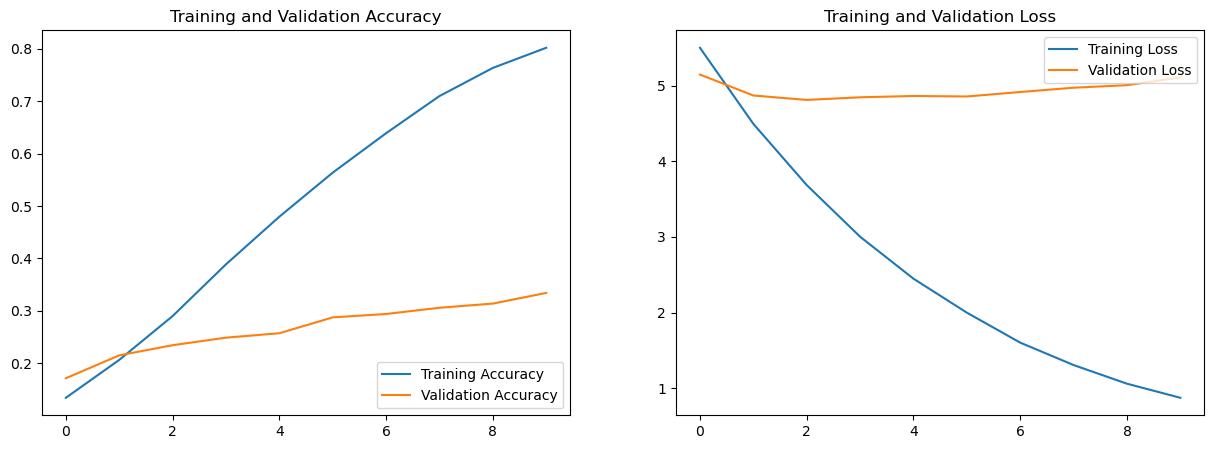

Average Validation Accuracy: 0.27
Average epoch time: 336.86 seconds


In [90]:
model_name = 'EfficientNetV2M'  
model_EfficientNetV2M = prepare_model(model_name, num_classes)
history = train_model(model_EfficientNetV2M, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')
average_epoch_time = time_callback.average_time_per_epoch
print(f'Average epoch time: {average_epoch_time:.2f} seconds')

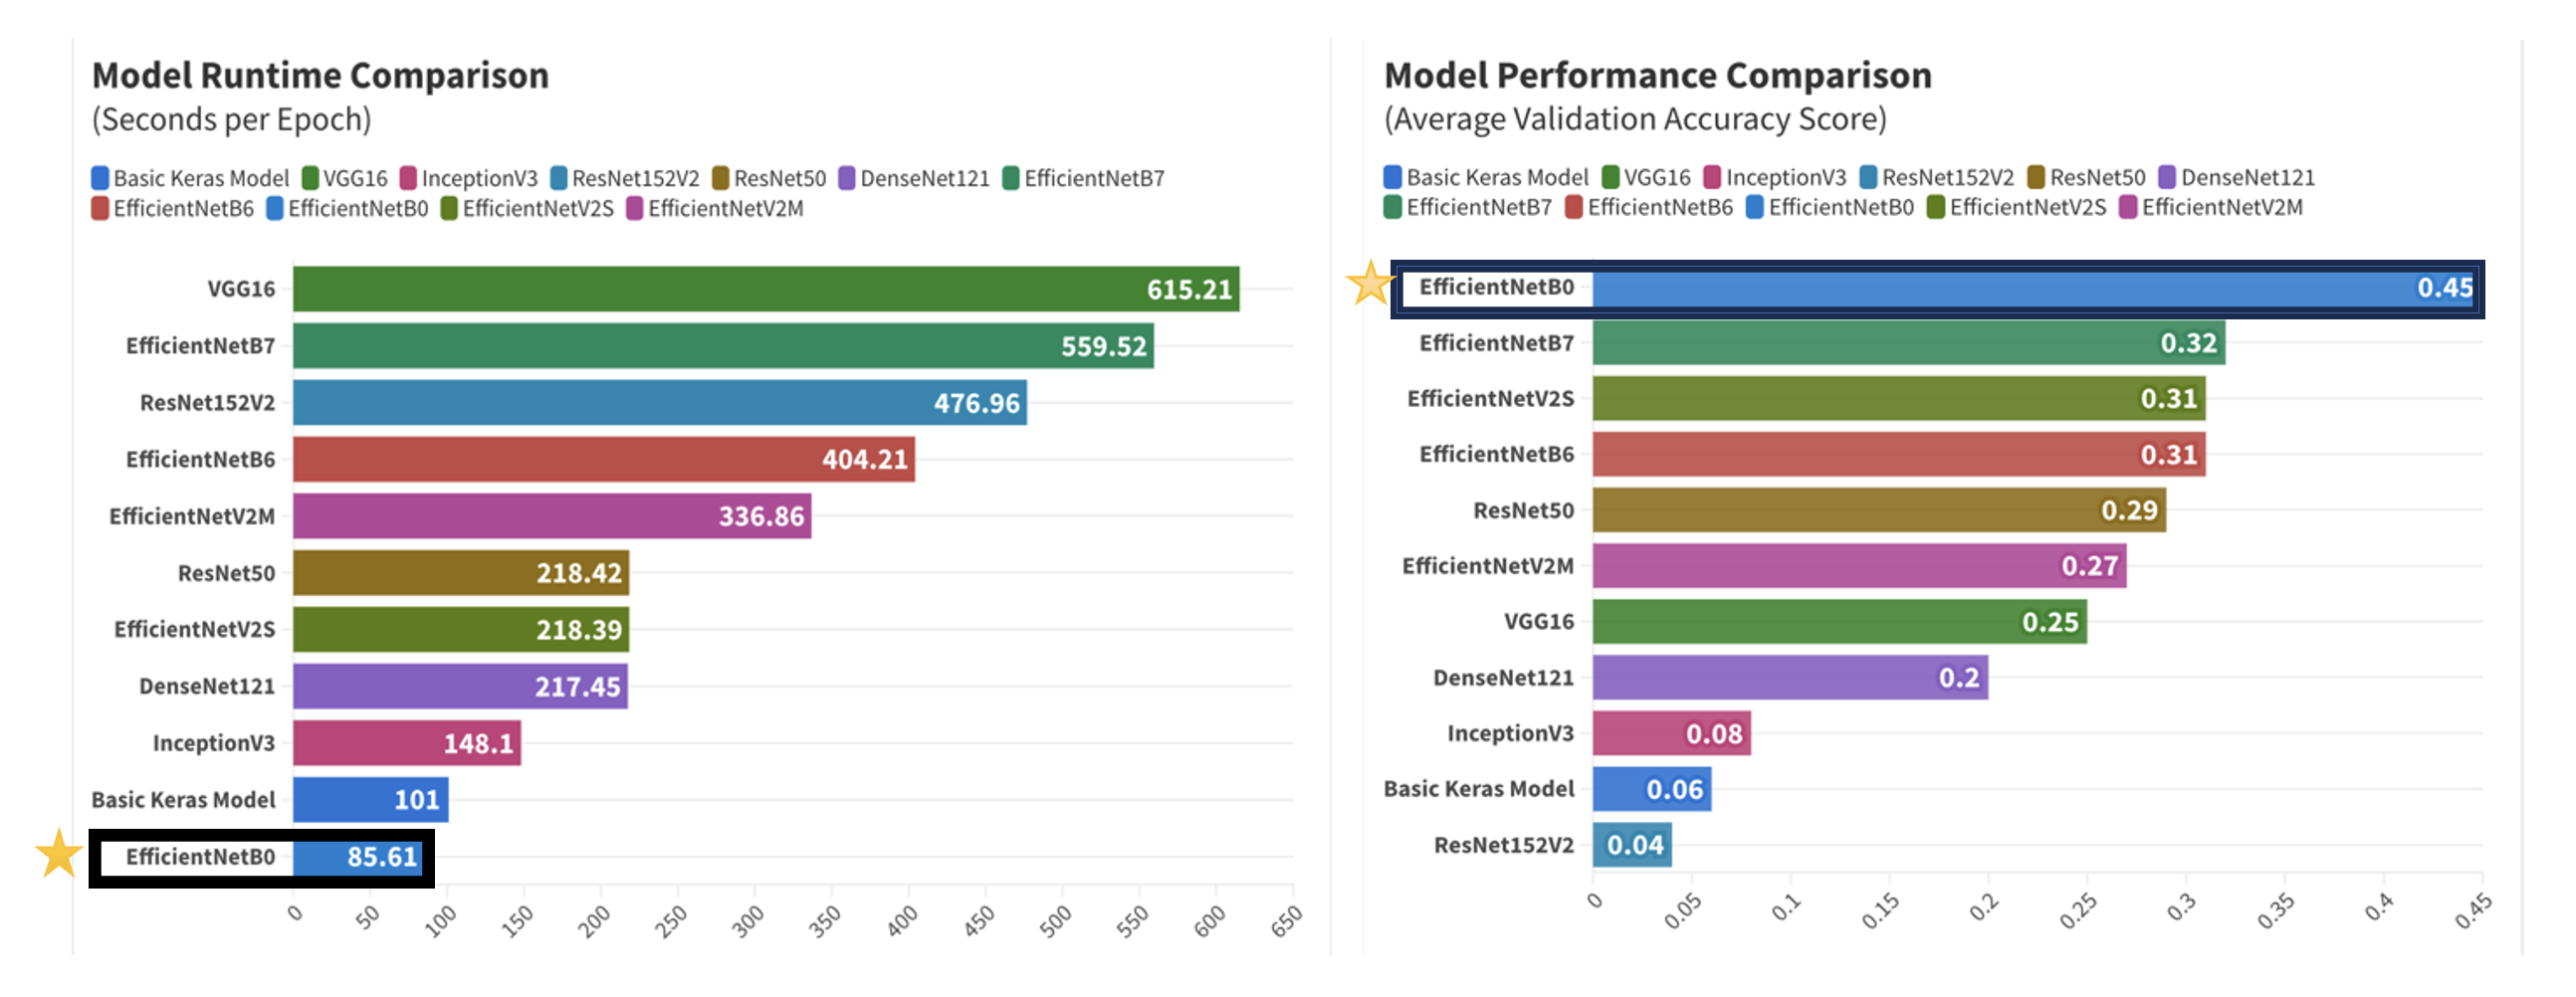

## **Part IV: Our best model-EfficientB0: more tuning and incorporating ArcFace**

**Among all the pre-trained models, EfficientNetB0 stood out; we continue to use the EfficientNetB0 architecture as a base, leveraging transfer learning, regularization, and data augmentation to enhance performance on potentially complex datasets.**

In [91]:
def build_model(num_classes, input_shape=(256, 256, 3), l1_factor=0, l2_factor=0, dropout_rate=0, use_data_augmentation=False):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    if use_data_augmentation:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),  
            layers.RandomRotation(0.2),  
            layers.RandomZoom(0.2),  
            layers.RandomContrast(factor=0.1),  
            layers.RandomBrightness(factor=0.1),  
            layers.Resizing(280, 280),  
            layers.RandomCrop(height=256, width=256),  
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
        ])
        x = data_augmentation(x)
    
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_factor, l2=l2_factor))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1_l2(l1=l1_factor, l2=l2_factor))(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def compile_and_fit(model, train_dataset, validation_dataset, epochs=50):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=1)
    return history

Epoch 1/50
197/197 [==============================] - 88s 434ms/step - loss: 5.1751 - accuracy: 0.1781 - val_loss: 4.7174 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 86s 430ms/step - loss: 3.5009 - accuracy: 0.3307 - val_loss: 4.1868 - val_accuracy: 0.3065
Epoch 3/50
197/197 [==============================] - 86s 429ms/step - loss: 2.0445 - accuracy: 0.5755 - val_loss: 3.9986 - val_accuracy: 0.3477
Epoch 4/50
197/197 [==============================] - 86s 429ms/step - loss: 1.0636 - accuracy: 0.7869 - val_loss: 3.9370 - val_accuracy: 0.3839
Epoch 5/50
197/197 [==============================] - 86s 430ms/step - loss: 0.5143 - accuracy: 0.9140 - val_loss: 3.9270 - val_accuracy: 0.3958
Epoch 6/50
197/197 [==============================] - 86s 430ms/step - loss: 0.2407 - accuracy: 0.9739 - val_loss: 3.9084 - val_accuracy: 0.4187
Epoch 7/50
197/197 [==============================] - 86s 430ms/step - loss: 0.1111 - accuracy: 0.9945 - val_loss: 3.8168 - val_ac

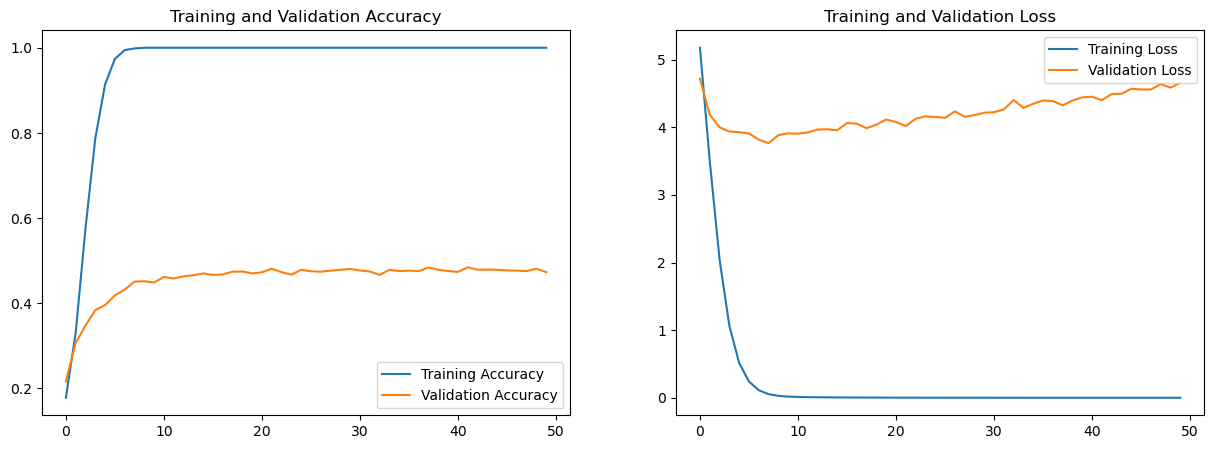

In [92]:
#EfficientNetB0 Model without augmentation, drop out or regularization
Efficient_base_model = build_model(num_classes)
history = compile_and_fit(Efficient_base_model, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 97s 481ms/step - loss: 6.0743 - accuracy: 0.1444 - val_loss: 5.9128 - val_accuracy: 0.1677
Epoch 2/50
197/197 [==============================] - 95s 477ms/step - loss: 5.1693 - accuracy: 0.2198 - val_loss: 5.5218 - val_accuracy: 0.1974
Epoch 3/50
197/197 [==============================] - 95s 476ms/step - loss: 4.5993 - accuracy: 0.2746 - val_loss: 5.5132 - val_accuracy: 0.2004
Epoch 4/50
197/197 [==============================] - 95s 477ms/step - loss: 4.1902 - accuracy: 0.3393 - val_loss: 5.3526 - val_accuracy: 0.2341
Epoch 5/50
197/197 [==============================] - 95s 476ms/step - loss: 3.9014 - accuracy: 0.3818 - val_loss: 5.2758 - val_accuracy: 0.2445
Epoch 6/50
197/197 [==============================] - 95s 478ms/step - loss: 3.6318 - accuracy: 0.4308 - val_loss: 5.1916 - val_accuracy: 0.2664
Epoch 7/50
197/197 [==============================] - 95s 476ms/step - loss: 3.4399 - accuracy: 0.4698 - val_loss: 5.2614 - val_ac

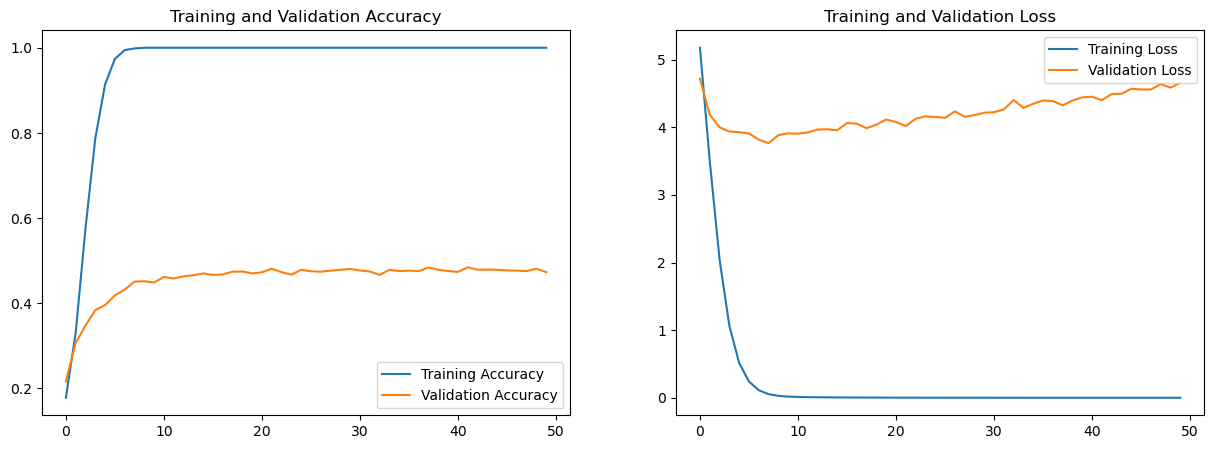

In [93]:
#EfficientNetB0 Model with l1+l2 Regularization, dropout and augmentation
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4, dropout_rate=0.2, use_data_augmentation=True)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 87s 426ms/step - loss: 5.8355 - accuracy: 0.1794 - val_loss: 5.3827 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 84s 423ms/step - loss: 4.3678 - accuracy: 0.3181 - val_loss: 4.9465 - val_accuracy: 0.2932
Epoch 3/50
197/197 [==============================] - 85s 424ms/step - loss: 3.2360 - accuracy: 0.5162 - val_loss: 4.8366 - val_accuracy: 0.3363
Epoch 4/50
197/197 [==============================] - 85s 425ms/step - loss: 2.4728 - accuracy: 0.6953 - val_loss: 4.7331 - val_accuracy: 0.3750
Epoch 5/50
197/197 [==============================] - 85s 425ms/step - loss: 1.9683 - accuracy: 0.8354 - val_loss: 4.7397 - val_accuracy: 0.3929
Epoch 6/50
197/197 [==============================] - 84s 424ms/step - loss: 1.6689 - accuracy: 0.9172 - val_loss: 4.7499 - val_accuracy: 0.4013
Epoch 7/50
197/197 [==============================] - 85s 424ms/step - loss: 1.4901 - accuracy: 0.9615 - val_loss: 4.6659 - val_ac

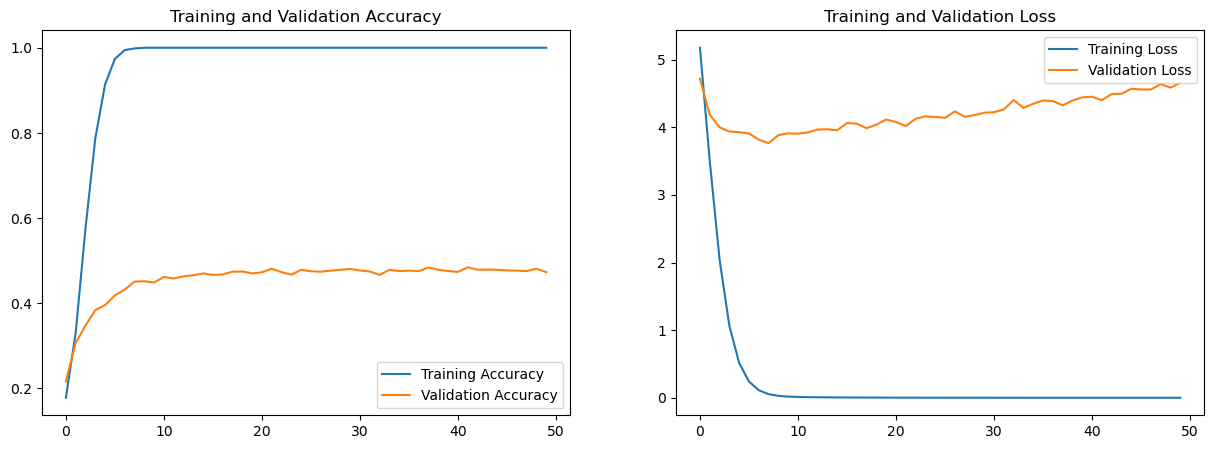

In [94]:
#EfficientNetB0 Model with l1+l2 Regularization
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 86s 422ms/step - loss: 5.2396 - accuracy: 0.1713 - val_loss: 4.7845 - val_accuracy: 0.2088
Epoch 2/50
197/197 [==============================] - 84s 420ms/step - loss: 3.7204 - accuracy: 0.3027 - val_loss: 4.2212 - val_accuracy: 0.2922
Epoch 3/50
197/197 [==============================] - 84s 419ms/step - loss: 2.3586 - accuracy: 0.5131 - val_loss: 4.0464 - val_accuracy: 0.3333
Epoch 4/50
197/197 [==============================] - 84s 420ms/step - loss: 1.3975 - accuracy: 0.7065 - val_loss: 3.9571 - val_accuracy: 0.3690
Epoch 5/50
197/197 [==============================] - 84s 421ms/step - loss: 0.8081 - accuracy: 0.8387 - val_loss: 4.0053 - val_accuracy: 0.3934
Epoch 6/50
197/197 [==============================] - 84s 423ms/step - loss: 0.4670 - accuracy: 0.9172 - val_loss: 3.9411 - val_accuracy: 0.4107
Epoch 7/50
197/197 [==============================] - 84s 421ms/step - loss: 0.2831 - accuracy: 0.9584 - val_loss: 3.9097 - val_ac

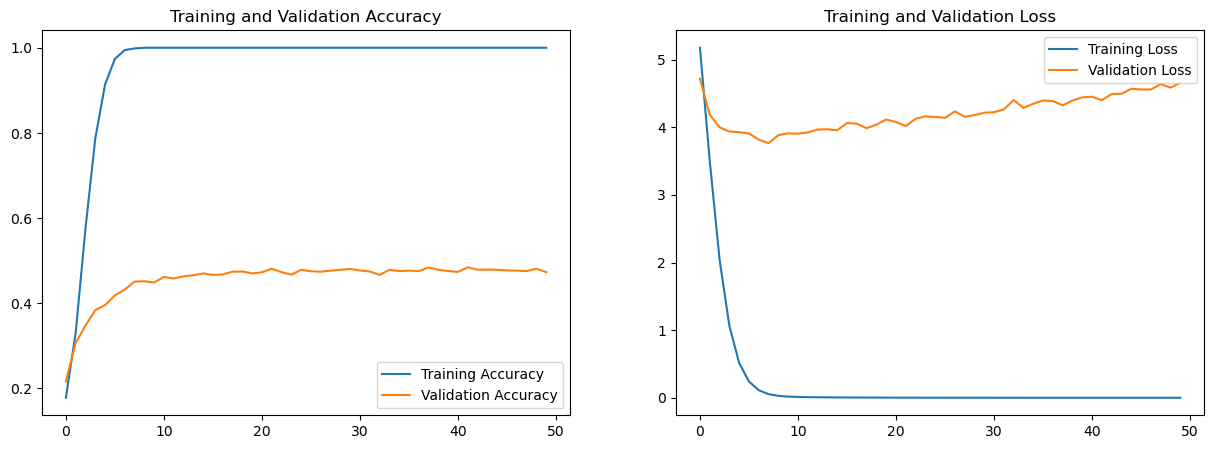

In [95]:
#EfficientNetB0 Model with dropout (0.2)
model_with_reg = build_model(num_classes, dropout_rate=0.2)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 95s 470ms/step - loss: 5.3838 - accuracy: 0.1455 - val_loss: 5.1783 - val_accuracy: 0.1627
Epoch 2/50
197/197 [==============================] - 93s 468ms/step - loss: 4.3594 - accuracy: 0.2301 - val_loss: 4.8396 - val_accuracy: 0.1939
Epoch 3/50
197/197 [==============================] - 93s 467ms/step - loss: 3.5861 - accuracy: 0.3118 - val_loss: 4.5961 - val_accuracy: 0.2376
Epoch 4/50
197/197 [==============================] - 93s 469ms/step - loss: 3.0371 - accuracy: 0.3896 - val_loss: 4.5333 - val_accuracy: 0.2426
Epoch 5/50
197/197 [==============================] - 93s 468ms/step - loss: 2.5702 - accuracy: 0.4645 - val_loss: 4.5568 - val_accuracy: 0.2445
Epoch 6/50
197/197 [==============================] - 93s 468ms/step - loss: 2.2149 - accuracy: 0.5243 - val_loss: 4.4283 - val_accuracy: 0.2654
Epoch 7/50
197/197 [==============================] - 93s 467ms/step - loss: 1.9049 - accuracy: 0.5765 - val_loss: 4.4406 - val_ac

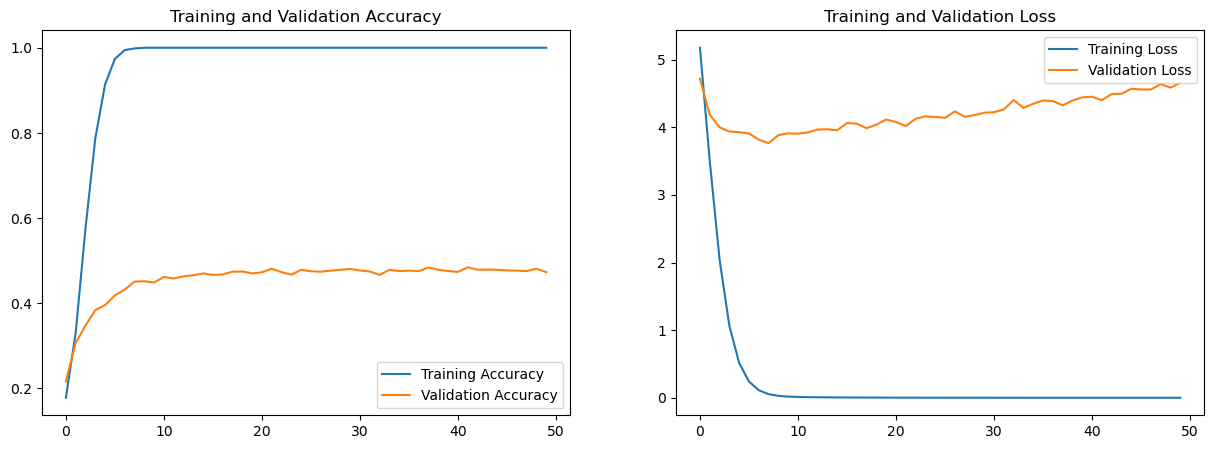

In [96]:
#EfficientNetB0 Model with augmentation
model_with_reg = build_model(num_classes, use_data_augmentation=True)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 84s 417ms/step - loss: 5.9272 - accuracy: 0.1708 - val_loss: 5.4467 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 83s 415ms/step - loss: 4.5884 - accuracy: 0.2885 - val_loss: 5.0392 - val_accuracy: 0.2803
Epoch 3/50
197/197 [==============================] - 83s 416ms/step - loss: 3.5430 - accuracy: 0.4544 - val_loss: 4.8693 - val_accuracy: 0.3269
Epoch 4/50
197/197 [==============================] - 83s 415ms/step - loss: 2.8033 - accuracy: 0.6219 - val_loss: 4.7714 - val_accuracy: 0.3676
Epoch 5/50
197/197 [==============================] - 83s 414ms/step - loss: 2.3183 - accuracy: 0.7491 - val_loss: 4.8376 - val_accuracy: 0.3705
Epoch 6/50
197/197 [==============================] - 83s 416ms/step - loss: 2.0095 - accuracy: 0.8297 - val_loss: 4.7621 - val_accuracy: 0.3988
Epoch 7/50
197/197 [==============================] - 83s 415ms/step - loss: 1.8086 - accuracy: 0.8933 - val_loss: 4.7892 - val_ac

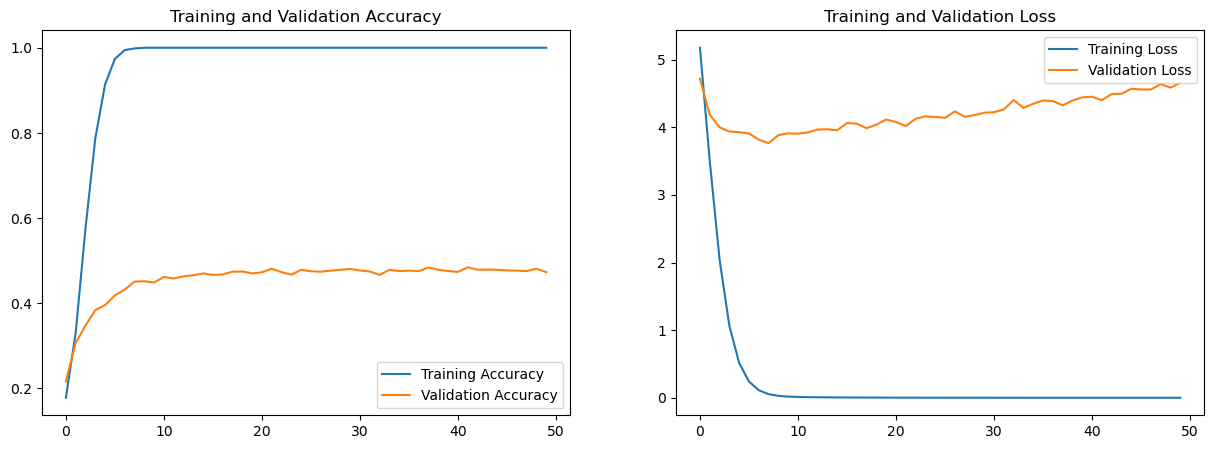

In [97]:
#EfficientNetB0 Model with l1+l2 Regularization and dropout 
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4, dropout_rate=0.2)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

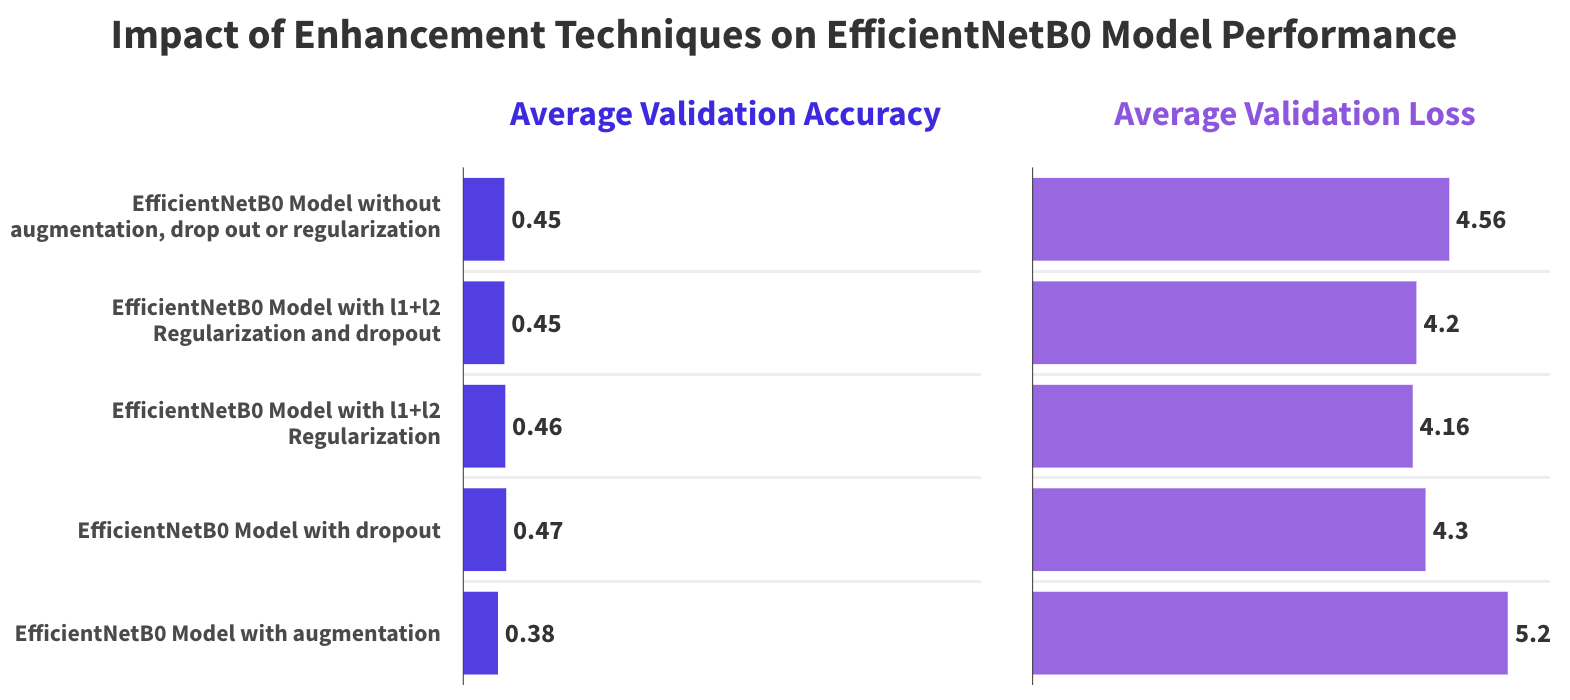

After rigorous experimentation with various configurations of the EfficientNetB0 model, we observed marginal enhancements in validation accuracy and a slight reduction in validation loss. However, the performance gains have plateaued, indicating a potential limitation in the capacity of the base model to learn more complex patterns or generalize further from our dataset. It suggests that we may have reached the intrinsic performance ceiling of the EfficientNetB0 architecture for our specific application. In pursuit of more substantial improvements, we have decided to transition our efforts to the ArcFace method.

### **What is ArcFace? Why ArcFace?**

The ArcMarginProduct class, inspired by the ArcFace method, is a custom TensorFlow layer designed to **significantly enhance the discriminative power of feature embeddings** in deep learning models, particularly beneficial for classification tasks where subtle differences between classes, such as facial features or hotel rooms, are paramount. ArcFace stands out for its innovative approach of enforcing an angular margin between classes in the feature space. This technique effectively amplifies the model's **sensitivity to intra-class variations** and ensures a clearer separation between different classes.

<img width="1300" alt="Screenshot 2024-02-10 at 5 47 44 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/347415ed-0fea-43fa-b38f-6f777098c0f7">

By adjusting the cosine distance between feature vectors and class centers with a **scale (s) and margin (m)** parameter, ArcFace makes the model more adept at distinguishing between closely related categories. The ArcMarginProduct layer implements this by applying the angular margin in the cosine space, offering options for easy margin settings and **label smoothing (ls_eps)** to promote training stability and enhance generalization. This layer is particularly useful in scenarios demanding high discriminative capabilities, such as identifying nuanced differences in hotel room categories or in facial recognition tasks, ensuring the model learns robust and distinct features for each class, thereby improving accuracy and generalization in scenarios characterized by subtle variances.

<img width="1176" alt="Screenshot 2024-02-10 at 5 48 22 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/c4559c51-fc88-44e3-9126-676c95ded963">

#### **References:**
##### 1. https://arxiv.org/pdf/1801.07698.pdf (**Authors:** Jiankang Deng, Jia Guo, Jing Yang, Niannan Xue, Irene Kotsia, and Stefanos Zafeiriou)
##### 2. [How to train with ArcFace loss to improve model classification accuracy | by Yiwen Lai](https://yiwenlai.medium.com/how-to-train-with-arcface-loss-to-improve-model-classification-accuracy-d4035195aeb9) (**Author:** Yiwen Lai)
##### 3. https://github.com/Niellai/ObjectDetection/blob/master/10_COVID19_ArcFace.ipynb?source=post_page-----d4035195aeb9-------------------------------- (**Author:** Niel Lai)
##### 4. https://www.kaggle.com/code/hidehisaarai1213/glret21-efficientnetb0-baseline-inference/notebook (**Author:** Hidehisa Arai)
##### 5. https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py (**Author:** Lyakaap)

**Preparing dataset for ArcFace**

In [5]:
def prepare_for_arcface(images, labels):
    return (images, labels), labels

subset_train_dataset = subset_train_dataset.map(prepare_for_arcface)
subset_validation_dataset = subset_validation_dataset.map(prepare_for_arcface)
subset_test_dataset = subset_test_dataset.map(prepare_for_arcface)

In [6]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf (Authors: Jiankang Deng, Jia Guo, Jing Yang, Niannan Xue, Irene Kotsia, and Stefanos Zafeiriou)
        https://www.kaggle.com/code/hidehisaarai1213/glret21-efficientnetb0-baseline-inference/notebook (Author: Hidehisa Arai)
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/ 
            blob/master/src/modeling/metric_learning.py (Author: Lyakaap)
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

**We freeze all but the last three layers of EfficientNetB0 for feature extraction, apply global average pooling, and optionally include dropout for regularization. The ArcMarginProduct layer, which requires both feature and label inputs, is utilized to enforce an angular margin that enhances the separability between classes.**

In [7]:
def build_model_with_arcface(num_classes, input_shape=(256, 256, 3), dropout_rate=0, l1_factor=0, l2_factor=0):
    '''
    Build model using EfficientNetB0 as base and ArcFace as output layer.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf(Authors: Jiankang Deng, Jia Guo, Jing Yang, Niannan Xue, Irene Kotsia, and Stefanos Zafeiriou)
        How to train with ArcFace loss to improve model classification accuracy | by Yiwen Lai (Author: Yiwen Lai)
        https://github.com/Niellai/ObjectDetection/blob/master/10_COVID19_ArcFace.ipynb?source=post_page-----d4035195aeb9--------------------------------(Author: Niel Lai)
        https://www.kaggle.com/code/hidehisaarai1213/glret21-efficientnetb0-baseline-inference/notebook (Author: Hidehisa Arai)

    '''
    premodel = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    
    # Freeze the layers except the last 3
    for layer in premodel.layers[:-3]:
        layer.trainable = False
    
    # Define the input layers
    inputs = tf.keras.Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))  # Additional input for labels
    
    # Forward pass through the base model
    x = premodel(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_factor, l2=l2_factor))(x)
    
    output = ArcMarginProduct(n_classes=num_classes, s=30.0, m=0.5)([x, label_input])
    
    model = Model([inputs, label_input], output)
    
    return model

def compile_and_fit(model, train_dataset, validation_dataset, epochs=30, callbacks=None):
    
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=callbacks,  
        verbose=1,
    )
    return history

In [8]:
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_path = os.path.join(checkpoint_dir, 'best_model.h5')

callbacks = [
    ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min'),
]

input_shape = (256, 256, 3)
num_classes = 500  
dropout_rate = 0.2
l1_factor = 1e-4
l2_factor = 1e-4
model = build_model_with_arcface(num_classes, input_shape, l1_factor, l2_factor, dropout_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 8, 8, 1280)           4049571   ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['efficientnetb0[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                              

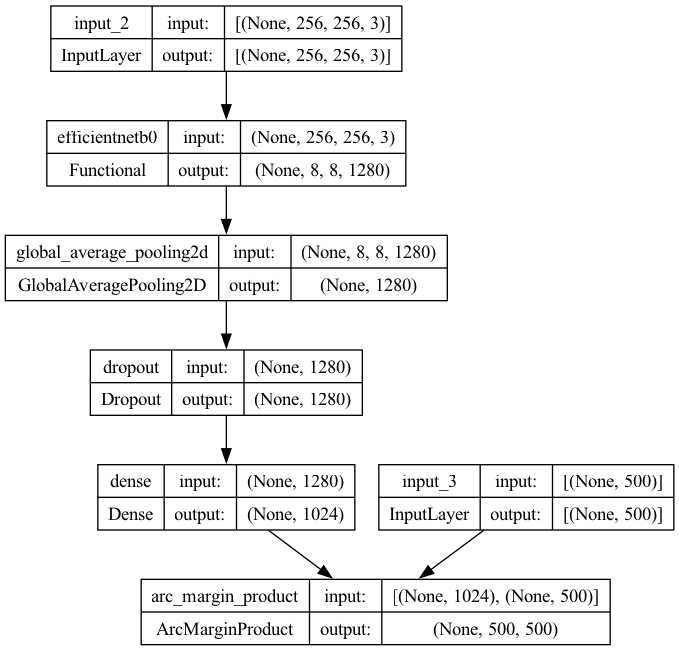

In [17]:
os.environ['PATH'] += os.pathsep + '/opt/homebrew/bin'
plot_model(model, to_file='model_architecture.png', show_shapes=True)
Image(filename='model_architecture.png')

In [14]:
history = compile_and_fit(model, subset_train_dataset, subset_validation_dataset, epochs=30, callbacks=callbacks)

test_loss, test_accuracy = model.evaluate(subset_test_dataset)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

Epoch 1/30
197/197 [==============================] - ETA: 0s - loss: 35.7941 - accuracy: 0.0561
Epoch 1: val_accuracy improved from -inf to 0.10218, saving model to model_checkpoints/best_model.h5
197/197 [==============================] - 79s 391ms/step - loss: 35.7941 - accuracy: 0.0561 - val_loss: 15.1668 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 2/30


/Users/yiyiluo/miniconda3/envs/capstone/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - ETA: 0s - loss: 12.2510 - accuracy: 0.1052
Epoch 2: val_accuracy did not improve from 0.10218
197/197 [==============================] - 80s 399ms/step - loss: 12.2510 - accuracy: 0.1052 - val_loss: 11.6201 - val_accuracy: 0.0918 - lr: 0.0010
Epoch 3/30
197/197 [==============================] - ETA: 0s - loss: 11.6091 - accuracy: 0.1066
Epoch 3: val_accuracy did not improve from 0.10218
197/197 [==============================] - 81s 404ms/step - loss: 11.6091 - accuracy: 0.1066 - val_loss: 12.0127 - val_accuracy: 0.0903 - lr: 0.0010
Epoch 4/30
197/197 [==============================] - ETA: 0s - loss: 11.5362 - accuracy: 0.1268
Epoch 4: val_accuracy improved from 0.10218 to 0.11607, saving model to model_checkpoints/best_model.h5
197/197 [==============================] - 83s 415ms/step - loss: 11.5362 - accuracy: 0.1268 - val_loss: 11.5858 - val_accuracy: 0.1161 - lr: 0.0010
Epoch 5/30
197/197 [==============================] - ETA: 0s - los

**Note:** Incorporating the ArcFace method into our EfficientNetB0 model represents a strategic pivot towards leveraging advanced techniques to enhance feature discrimination. However, the optimization of such sophisticated methods requires extensive experimentation and tuning to fully realize their potential. Given the constraints of our capstone project's timeline, we have not yet achieved the optimal configuration of the ArcFace-enhanced EfficientNetB0 model that surpasses the performance of other models. As of the submission of this minimum viable product (MVP) notebook, our exploration into fine-tuning and experimentation is ongoing. We anticipate that with additional time and iterative refinement, the integration of ArcFace will yield significant performance improvements and set a new benchmark for our model's capabilities.

## **Part V: Conclusions and Next Steps**

### **Project Conclusions:** 

The project's advancement is currently hampered by a scarcity of data. Identifying ways to augment the dataset is imperative for the continued improvement of the model's performance. **Optimal Model Selection:** EfficientNetB0 has been identified as the superior base model, delivering top-notch performance in accuracy and training time when compared with a custom-built Keras model and other advanced pre-trained models.
**ArcFace Enhancement:** The integration of ArcFace into our leading base model has shown considerable potential. Despite the time constraints of the capstone project preventing full optimization, the initial findings suggest that further tuning could yield superior results.


### **Next Steps for Progress:**

**1. Expanding Dataset Application:** Building on the success with a subset, plans are in place to extend the application to the full dataset, with the expectation of further honing the model's accuracy.

**2. Advanced Model Experimentation:** The exploration of cutting-edge models is set to continue. Ensemble methods will be investigated to amalgamate the unique advantages of each model, thereby enhancing overall efficacy.

**3. Hyperparameter Optimization:** A key focus will be to fine-tune ArcFace's hyperparameters, with ongoing experiments aimed at optimizing its performance within the model framework.

**Each step taken towards optimizing the model's performance is a step towards the noble aim of rescuing more lives. The commitment to this cause remains the project's driving force.**

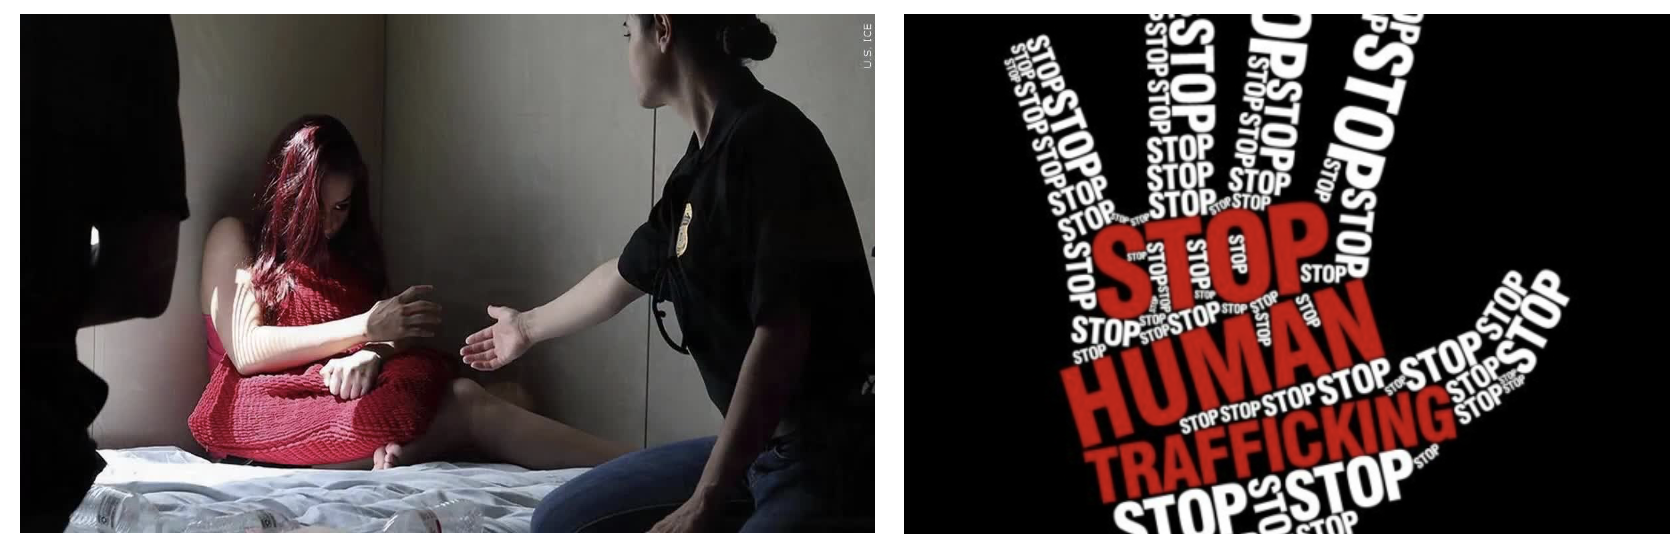